# Thinking with Deep Learning: Week 2 Part 2
# Optimization and Regularisation for Deep Neural Architectures

__Instructor:__ James Evans

__Notebook Author:__ Bhargav Srinivasa Desikan

__Teaching Assistants & Course Organizers:__ Likun Cao & Partha Kadambi

In this notebook we will focus on the many techniques which actually get neural networks to run - optimization and regularisation. In the last notebook we focused on quickly getting models whipped up and ready to go for a variety of tasks, data and settings. In this notebook our approach will be quite different, and we will rather focus on working on just one kind of problem, of image classification - by keeping the problem fixed, we can then focus on what each of the different optimisation and regularisation procedures do.

This notebooks features some code and concepts from the UPenn CS-522 course, specifically their [week 4 on Optimisation](https://github.com/CIS-522/course-content/tree/main/tutorials/W04_Optimization), and [week 5 on Regularisation](https://github.com/CIS-522/course-content/tree/main/tutorials/W05_Regularization), and we are grateful for their content and support! We would also highly recommend them as resources for more code and content on optimisation, regularisation, and other content on deep learning. (We are co-teaching a summer Deep Learning Academy with them this summer).

**Notes about the tutorial**: Much like the last tutorial, there is a lot more code here. Once again, a lot of that code is just to setup data and some of the neural nets, and we have tried to comment the code as extensively as possible. Like last time, we highly recommend looking at the homework at the bottom of the notebook so that you can manage your time on the notebook better. Getting to know about the possible range of optimization options and regularisation options is a necessary exercise to get the most out of your deep neural models. Throughout this notebook, you will also encounter some exploratory questions. You need not answer them in the notebook but you are encouraged to search for the answers (or ask us if you can't find them!)

Your purpose in this notebook is to be able to adapt your Keras or PyTorch models with the various techniques we discuss below. All the primary code in the notebook is in PyTorch with links to resources or documentation for similar options in Keras.


# Optimization

Optimization in a neural network refers to the process of adjusting the weights of your neural network on the way to make a better prediction. Here, we are attempting to find a local minima which minimizes the error of the predictions made. Here are some basic resources to read up on the topic:

[Neural Network Optimization](https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0). 

[Parameter and weights optimization for Neural Networks](https://www.deeplearning.ai/ai-notes/optimization/).

In [1]:
# imports
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import requests
import io
from urllib.request import urlopen


---
## Minibatch stochastic gradient descent (SGD)

In stochastic gradient descent, we replace the actual gradient vector with a stochastic estimation of the gradient vector. Specifically for a neural network, the stochastic estimation uses the gradient of the loss for a single data point (single instance).

Given $f_i=l(x_i, y_i, w)$, the expected value of the $t$-th step of SGD is the same as the $t$-th step of full gradient descent.

$$\mathbb{E}[w_{t+1}]=w_t-\eta \mathbb{E}[\nabla f_i(w_t)]=w_t-\eta\nabla f(w_t)$$

where $i$ is chosen uniformly at random, thereby $f_i$ is a noisy but unbiased estimator of $f$.

$$w_{t+1}=w_t-\eta\nabla f_i(w_t)$$

We update the weights according to the gradient over $f_i$ (as opposed to the gradient over the total loss $f$).

SGD advantages:
*   The noise in the SGD update can prevent convergence to a bad (shallow) local minima.
*   It is drastically cheaper to compute (as you don’t go over all data points).


### Minibatching

Often we are able to make better use of our hardware by using mini batches instead of single instances. We compute the loss over a mini-batch -- a set of randomly selected instances instead of calculating it over just one instance. This reduces the noise in the step update.

Given the $t$th minibatch $B_t$ consisting of $k$ observations: 

$$w_{t+1}=w_t-\eta \frac{1}{|B_t|}\sum_{i\in B}\nabla f_i(w_t)$$


One of the main constraints of training deep neural networks is the relatively limited size of GPU memory. Being able to quickly estimate if your minibatch size can be held in that memory will save you time and out-of-memory errors.

What do we need to store at training time? 
- outputs of intermediate layers (forward pass): 
- model parameters
- error signal at each neuron
- the gradient of parameters
plus any extra memory needed by optimizer (e.g. for momentum)



In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # set optimiser to zero
        optimizer.zero_grad()
        # pass the data through the model
        output = model(data)
        # calculate loss
        loss = F.nll_loss(output, target)
        # backprop
        loss.backward()
        # move optimiser
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [5]:
def main(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    acc_list, time_list = [], []
    start_time = time.time()
    for epoch in range(1, args['epochs'] + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        time_list.append(time.time()-start_time)
        acc = test(model, device, test_loader)
        acc_list.append(acc)

    return acc_list, time_list

In [6]:
# Training settings
args = {'batch_size': 32,
        'test_batch_size': 1000,
        'epochs': 3,
        'lr': 0.01,
        'momentum': 0.9,
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

batch_size = [8, 16, 32, 64, 256, 512, 1024]
acc_dict = {}
test_acc = []

In [7]:


for i in range(len(batch_size)):
    args['batch_size'] = batch_size[i]
    acc, timer = main(args)
    acc_dict['acc'+str(batch_size[i])] = acc
    acc_dict['time'+str(batch_size[i])] = timer
    test_acc.append(acc[-1])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.394294


C:\Users\parth\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 1 [800/60000 (1%)]	Loss: 0.265935
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.593158
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.237826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.653904
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.389669
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.794406
Train Epoch: 1 [5600/60000 (9%)]	Loss: 0.288085
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.062109
Train Epoch: 1 [7200/60000 (12%)]	Loss: 0.078927
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.013031
Train Epoch: 1 [8800/60000 (15%)]	Loss: 1.363157
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.128104
Train Epoch: 1 [10400/60000 (17%)]	Loss: 0.003276
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.655168
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.185138
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.243229
Train Epoch: 1 [13600/60000 (23%)]	Loss: 0.074574
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.437198
Train Epoch: 1 [15200/60000 (25%)]	Loss: 0.057742
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.342083
Train Epoch: 1 [1680

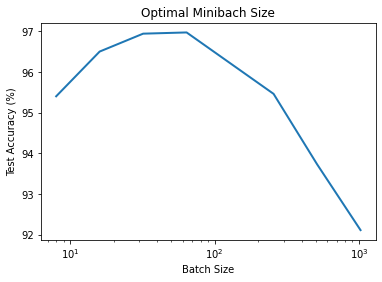

In [8]:

plt.plot(batch_size, test_acc, linewidth=2)
plt.title('Optimal Minibach Size')
plt.ylabel('Test Accuracy (%)')
plt.xscale('log')
plt.xlabel('Batch Size')
plt.savefig('minibatch.png')
plt.show()

---
## Batch normalization

Rather than improving the optimization algorithms, batch normalization improves the network structure itself by adding additional layers in between existing layers. The goal is to improve the optimization and generalization performance.

In neural networks, we typically alternate linear (weighted summation) operations with non-linear operations, the activation functions, such as ReLU. The most common practice is to put the normalization between the linear layers and activation functions.

More formally, normalization is as follows:
$$\tilde x_j = a\frac{x_j-\mu_j}{\sigma_j}+b$$
where
*   $x_j$ is the output of a neuron or, equivalently, the input to the next layer,
*   $\tilde x_j$ is that same feature after being normalized ,
*   $\mu_j$ is the mean of the feature $x_j$ over the minibatch,
*   $\sigma_j$ is the estimate of the standard deviation of $x_j$ over the minibatch (with $\epsilon$ added, so we don't divide by zero),
*   $a$ is the learnable scaling factor,
*   $b$ is the learnable bias term.

Batch normalization tries to reduce the “internal covariate shift” between training and testing data. Internal covariate shift is the change in the distribution of network activations due to the change in paramaters during training. In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does the distribution of inputs to subsequent layers. These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers. Batch normalization tries to mitigate this. You can check out [this](https://arxiv.org/abs/1502.03167) paper where the idea of mitigating internal covariance shift with batch normalization was first introduced. 


The advantages of BN are as follows:

*   Networks with normalization layers are easier to optimize, allowing for the use of larger learning rates, speeding up the training of neural networks.
*   The mean/std deviation estimates are noisy due to the randomness of the samples in batch. This extra “noise” sometimes results in better generalization. Normalization has a regularization effect.
*   Normalization reduces sensitivity to weight initialization.


In [9]:
#help functions
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss /= len(train_loader.dataset)
    return avg_loss
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def bn_eval(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    if args['net_type'] == 'Shallow':
        model = Net().to(device)
    elif args['net_type'] == 'BNShallow':
        model = BNShallowNet().to(device)
    elif args['net_type'] == 'Deep':
        model = DeepNet().to(device)
    elif args['net_type'] == 'BNDeep':
        model = BNDeepNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        train_loss = train(args, model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        train_list.append(train_loss)
        test_list.append(test_loss)

    return train_list, test_list

In [10]:
#models
class BNShallowNet(nn.Module):
    def __init__(self):
        super(BNShallowNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [11]:
class BNDeepNet(nn.Module):
    def __init__(self):
        super(BNDeepNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        return output

In [12]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        return output

In [13]:
#train
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'net_type': 'Net',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

net = ['Shallow', 'BNShallow', 'Deep', 'BNDeep']
loss_dict = {}

for i in range(len(net)):
    args['net_type'] = net[i]
    train_loss, test_loss = bn_eval(args)
    loss_dict['train' + str(net[i])] = train_loss
    loss_dict['test' + str(net[i])] = test_loss

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316141
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.242406
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.235460
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.223956
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.155213
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.259829
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.089210
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.306485
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.240487
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.225086

Test set: Average loss: 0.1626, Accuracy: 9492/10000 (94.9200%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.136676
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.127483
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.126380
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.137696
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.086575
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.127791
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.049682
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.193840
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.151

## Momentum 

Momentum in gradient descent is similar to the concept of momentum in physics. The optimization process resembles a ball rolling down the hill. Momentum keeps the ball moving in the same direction that it is already moving in. The gradient can be thought of as a force pushing the ball in some other direction.

<p align="center">
  <img width="460" height="300" src="https://miro.medium.com/max/640/1*i1Qc2E0TVlPHEKG7LepXgA.gif">
</p>

Mathematically it can be expressed as follows-
$$w_{t+1}=w_t-\eta (\nabla f(w_t) +\beta m_{t}) $$
$$m_{t+1}= \nabla f(w_t) +\beta m_{t}$$
or, equivalently
$$w_{t+1}= w_t -\eta\nabla f(w_t) +\beta (w_{t} -w_{t-1})$$

where
*   $m$ is the momentum (the running average of the past gradients, initialized at zero),
*   $\beta\in [0,1)$ is the damping factor, usually $0.9$ or $0.99$.



Let’s consider two extreme cases to understand this decay rate parameter better. If the decay rate is 0, then it is exactly the same as (vanilla) gradient descent (blue ball). If the decay rate is 1 (and provided that the learning rate is reasonably small), then it rocks back and forth endlessly like the frictionless ball we saw previously; you do not want that. Typically the decay rate is chosen around 0.8–0.9 — it’s like a surface with a little bit of friction so it eventually slows down and stops (purple ball).

<p align="center">
  <img width="460" height="300" src="https://miro.medium.com/max/800/1*zVi4ayX9u0MQQwa90CnxVg.gif">
</p>



In [14]:
#useful link: 
#https://distill.pub/2017/momentum/

In the standard SGD formulation, every weight in network is updated with the same learning rate (global $\eta$). Here, we adapt a learning rate for each weight individually, using information we get from their gradients.

## Adagrad

Adagrad adapts the learning rate of each parameter, downweighting the learning rates for parameters that have changed a lot and upweighting the learning rates of parameters that have changed very little.

It uses a different learning rate for every parameter $w_j$ at every time step, $t$. (The time step here in practice is a minibatch, with everything averaged over that minibatch.) The update for every parameter $w_j$ at each time step (or epoch) $t$ then becomes

$$w_{t+1}=w_t- \frac{\eta}{\sqrt{v_{t+1}+\epsilon}} \nabla f(w_t)$$

where the equation holds for every feature $w_j$ separately. Thus, $\nabla f(w_{t})$ is the partial derivative of the objective function w.r.t. to the parameter $w_j$ at time step $t$ and the learning rate for each feature is scaled using the sum of the gradients for that feature:

$$v_{t+1} = \sum^t_{\tau=1} \nabla f(w_{\tau})^2$$

Adagrad effectively selects low learning rates for parameters associated with frequently occurring features, and high learning rates for parameters associated with infrequent features. It is thus well-suited for dealing with sparse data.


## RMSprop

RMSprop seeks to reduce Adagrad's aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, RMSprop restricts the window of accumulated past gradients to some fixed size. The sum of gradients is recursively defined as a decaying average of all past squared gradients.

$$w_{t+1}=w_t- \frac{\eta}{\sqrt{v_{t+1}+\epsilon}} \nabla f(w_t)$$
$$v_{t+1}=\alpha v_t+(1-\alpha)(\nabla f(w_t))^2$$

where 
*   $v$ is the 2nd moment estimate which depends (as a fraction $\alpha$ similarly to the Momentum term) on the previous average and the current gradient.
*   $\alpha$ is usually set to $0.9$, while a good default value for the learning rate $\eta$ is $0.001$.

We update $v$ to estimate this noisy quantity via an exponential moving average (which is a standard way of maintaining an average of a quantity that may change over time). We need to put larger weights on the newer values as they provide more information. One way to do that is down-weight old values exponentially. The values in the $v$ calculation that are very old are down-weighted at each step by an $\alpha$ constant, which varies between 0 and 1. This dampens the old values until they are no longer an important part of the exponential moving average.

## Adam

Adam (from "Adaptive moments") is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary.

The 

## Learn and compare different adaptive learning rate optimizers

For SGD with fixed schedule, Adagrad, RMSprop, Adam, how do they differ on train and test error? Which one works the best?

We compare these optimizers by performing digit classification task in MNIST.

In [15]:
def optimizer_eval(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    model = Net().to(device)
    if args['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args['lr'])
    elif args['optimizer'] == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=args['lr'])
    elif args['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
    elif args['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        train_acc = train(args, model, device, train_loader, optimizer, epoch)
        train_list.append(100.-train_acc)
        test_acc = test(model, device, test_loader)
        test_list.append(100.-test_acc)

    return train_list, test_list 

The training takes over 20 mins. Please skip running below cells for now and come back when time allows.

In [16]:
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'net_type': 'Net',
        'anneal_type': 'linear',
        'optimizer': 'sgd',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

In [17]:
optimizer = ['sgd', 'adagrad', 'rmsprop', 'adam']
error_dict = {}


In [18]:

for i in range(len(optimizer)):
    args['optimizer'] = optimizer[i]
    train_error, test_error = optimizer_eval(args)
    error_dict['train' + str(optimizer[i])] = train_error
    error_dict['test' + str(optimizer[i])] = test_error

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316141
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.873576
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.613212
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.505045
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.371770
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.430531
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.305042
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.439199
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.405678
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.406586

Test set: Average loss: 0.3245, Accuracy: 9075/10000 (90.7500%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.284757
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.250786
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.248573
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.356028
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.230832
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.338519
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.212139
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.369880
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.310

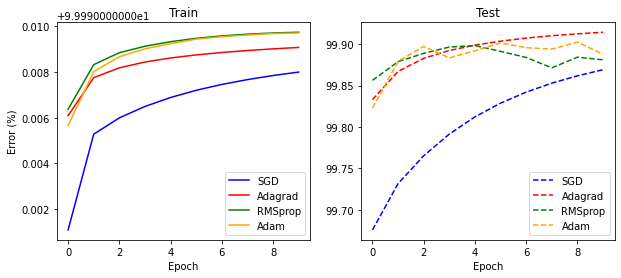

In [19]:
  fig, axs = plt.subplots(1, 2, figsize=(10,4))
  axs[0].plot(error_dict['trainsgd'], label='SGD', color='b')
  axs[1].plot(error_dict['testsgd'], label='SGD', color='b', linestyle='dashed')
  axs[0].plot(error_dict['trainadagrad'], label='Adagrad', color='r')
  axs[1].plot(error_dict['testadagrad'], label='Adagrad', color='r', linestyle='dashed')
  axs[0].plot(error_dict['trainrmsprop'], label='RMSprop', color='g')
  axs[1].plot(error_dict['testrmsprop'], label='RMSprop', color='g', linestyle='dashed')
  axs[0].plot(error_dict['trainadam'], label='Adam', color='orange')
  axs[1].plot(error_dict['testadam'], label='Adam', color='orange', linestyle='dashed')
  axs[0].set_title('Train')
  axs[1].set_title('Test')
  axs[0].set_ylabel('Error (%)')
  #plt.yscale('log')
  axs[0].set_xlabel('Epoch')
  axs[1].set_xlabel('Epoch')
  axs[0].legend()
  axs[1].legend()
  plt.show()

Plot the train and test classification error curves of different optimizers by running below cell.

## Learning rate scheduling

If the learning rate is too large, optimization diverges; if it is too small, it takes too long to train or we end up with a suboptimal result. People often start large learning rate and then 'decay' or 'anneal'(decrease) it.  This can help both optimization and generalization.

Common beliefs in how annealing works come from the optimization analysis of stochastic gradient descent: 

1.   An initial large learning rate accelerates training or helps the network escape spurious local minima
2.   Decaying the learning rate helps the network converge to a local minimum and avoid oscillation. 

The simplest learning rate schedule is to decrease the learning rate linearly from a large initial value to a small value. This allows large weight changes in the beginning of the learning process and small changes or fine-tuning towards the end of the learning process. There are other schedules such as square root and exponential decay. 


### Compare different annealing schedules: constant, linear, sqrt(t) and exp(-t)


Firstly, let's plot the simulation of different annealing scheduels: constant, linear, sqrt(t) and exp(-t) in below cell.

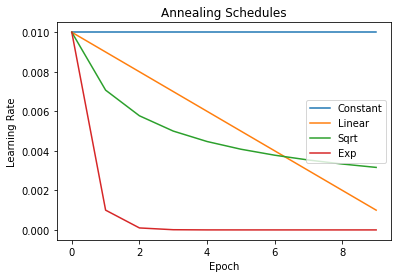

In [20]:
model = torch.nn.Linear(2, 1)
lr_anneal = ['constant', 'linear', 'sqrt', 'exp']
lr_dict = defaultdict(list)

for idx in range(len(lr_anneal)):
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    if lr_anneal[idx] == 'constant':
        lambda1 = lambda epoch: 1
    elif lr_anneal[idx] == 'linear':
        lambda1 = lambda epoch: max(1e-7, 1 - 0.1*epoch)
    elif lr_anneal[idx] == 'sqrt':
        lambda1 = lambda epoch: (epoch + 1.0) ** -0.5
    elif lr_anneal[idx] == 'exp':
        lambda1 = lambda epoch: 0.1 ** epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    for i in range(10):
        optimizer.step()
        lr_dict[lr_anneal[idx]].append(optimizer.param_groups[0]["lr"])
        scheduler.step()


plt.plot(range(10), lr_dict['constant'], label='Constant')
plt.plot(range(10), lr_dict['linear'], label='Linear')
plt.plot(range(10), lr_dict['sqrt'], label='Sqrt')
plt.plot(range(10), lr_dict['exp'], label='Exp')
plt.title('Annealing Schedules')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Now, check your assumption by running below digit classification example with different learning rate scheduelers: linear, sqrt(t) and exp(-t).

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(784, 128)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [22]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss, correct = (0., 0.)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        avg_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss /= len(train_loader.dataset)
    return 100. * correct / len(train_loader.dataset)


In [23]:

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [24]:
def schedular_eval(args):
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')

    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    if args['anneal_type'] == 'constant':
        lambda1 = lambda epoch: 1
    elif args['anneal_type'] == 'linear':
        lambda1 = lambda epoch: max(1e-7, 1 -0.1 * epoch)
    elif args['anneal_type'] == 'sqrt':
        lambda1 = lambda epoch: (epoch + 1.0) ** -0.5
    elif args['anneal_type'] == 'exp':
        lambda1 = lambda epoch: 0.1 ** epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        '''
        if epoch > 1:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        '''
        train_acc = train(args, model, device, train_loader, optimizer, epoch)
        train_list.append(100.-train_acc)
        test_acc = test(model, device, test_loader)
        test_list.append(100.-test_acc)
        scheduler.step()

    return train_list, test_list 

The training takes over 20 mins. Please skip running below cells for now and come back when (or if) time allows.

In [25]:
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'net_type': 'Net',
        'anneal_type': 'linear',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

In [26]:
lr_anneal = ['constant', 'linear', 'sqrt', 'exp']
error_dict = {}


In [27]:
for i in range(len(lr_anneal)):
    args['anneal_type'] = lr_anneal[i]
    train_error, test_error = schedular_eval(args)
    error_dict['train' + str(lr_anneal[i])] = train_error
    error_dict['test' + str(lr_anneal[i])] = test_error

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303157
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.263613
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.229233
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.279926
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.142762
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.258634
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.120852
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.279262
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.255393
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.241545

Test set: Average loss: 0.1606, Accuracy: 9485/10000 (94.8500%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.126115
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.176877
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.095467
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.141587
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.074580
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.154570
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.053329
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.176427
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.156

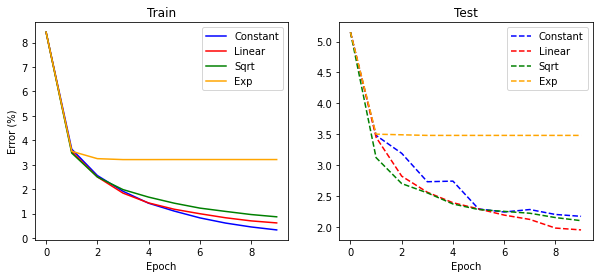

In [28]:

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(error_dict['trainconstant'], label='Constant', color='b')
axs[1].plot(error_dict['testconstant'], label='Constant', color='b', linestyle='dashed')
axs[0].plot(error_dict['trainlinear'], label='Linear', color='r')
axs[1].plot(error_dict['testlinear'], label='Linear', color='r', linestyle='dashed')
axs[0].plot(error_dict['trainsqrt'], label='Sqrt', color='g')
axs[1].plot(error_dict['testsqrt'], label='Sqrt', color='g', linestyle='dashed')
axs[0].plot(error_dict['trainexp'], label='Exp', color='orange')
axs[1].plot(error_dict['testexp'], label='Exp', color='orange', linestyle='dashed')
axs[0].set_title('Train')
axs[1].set_title('Test')
axs[0].set_ylabel('Error (%)')
#plt.yscale('log')
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.show()

## Concluding Optimisation

So we've seen a bunch of different optimizing methods, Batch Normalisation layers, and annealing methods which control the way the optimisation tapers off. Usually, we focus on optimisation technique and fine tuning after we've decided on the model we want to use on the data, though it is worth keeping an eye on the general optimisation techniques when we are training (such as the kind of optimiser we will be choosing). Optimisation works in tandem with the second set of topics we will be exploring, Regularisation, in part of being the key ways we truly master training a model. Model architecture and deciding the right kind of model for your data is crucial, but optimisation and regularisation is what it make the model ready for production (if that is your goal!).

So while optimisation dealt with the way our model back propagates information about changing the model weights based on the predictions, *regularisation* deals with ways we can allow our model to generalise better, and avoid over-fitting our model, and allowing it to be flexible in the way it deals with new data. In the following section, we will deal with multiple ways to regularise our data. We will continue dealing with image based models, but will move to a different dataset which is more complex, of animal faces.





## Keras Options

Here are set of links and resources for optimisation with Keras.

[Keras Optimizer Documentation](https://keras.io/api/optimizers/)

[Blog post on Keras optimizer options](https://machinelearningknowledge.ai/keras-optimizers-explained-with-examples-for-beginners/)


# Regularisation

Useful links:

- [Chapter 7, deep learning book](https://www.deeplearningbook.org/contents/regularization.html)
- [Slides and Code for PyTorch regularisation from Sebastian Raschka](https://github.com/rasbt/stat479-deep-learning-ss19/tree/master/L10_regularization)
- [towards data science blog post](https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036)
- [medium blog post](https://medium.com/@dhartidhami/regularization-in-deep-learning-2065b7c889e5)

## Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" that code and shown the resulting outputs.


In [50]:
#@title Import functions
from __future__ import print_function
import torch
import pathlib
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import StepLR
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from tqdm import tqdm
from IPython.display import HTML, display

In [51]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

## Loading Animal Faces data

The following cells setup our Animal Faces data source. If you run into trouble with any of these commands,
you can download the zip files directly from the github repos and unzip them manually.

In [64]:
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip

In [65]:
# @title Loading Animal Faces Randomized data

In [66]:
%%capture
!rm -r Animal_faces_random/
!git clone https://github.com/Ravi3191/Animal_faces_random.git
!rm -r afhq_random_32x32/
!unzip ./Animal_faces_random/afhq_random_32x32.zip
!rm -r afhq_10_32x32/
!unzip ./Animal_faces_random/afhq_10_32x32.zip

In [70]:
#@title Seeding for Reproducibility
seed = 90108
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.use_deterministic_algorithms(True)
def seed_worker(worker_id):
    worker_seed = seed % (worker_id+1)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [71]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

Now, lets define a Animal Net model, train, test and main functions which we will use quite frequently this week.

In [72]:
##Network Class - Animal Faces
class Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(104)
        super(Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

The train function takes in the current model along with the train_loader and loss function and updates the parameters for a single pass of the entire dataset. The test function takes in the current model after every epoch and calculates the accuracy on the test dataset.


In [73]:
def train(args, model, device, train_loader, optimizer, epoch,reg_function1=None,reg_function2=None,criterion=F.nll_loss):
    """
    Trains the current inpur model using the data 
    from Train_loader and Updates parameters for a single pass
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target)+args['lambda1']*reg_function1(model)+args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()

In [74]:
def test(model, device, test_loader, loader = 'Test',criterion=F.nll_loss):
    """
    Tests the current Model
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return 100. * correct / len(test_loader.dataset)

In [75]:
def main(args, model,train_loader,val_loader,test_data,reg_function1=None,reg_function2=None,criterion=F.nll_loss):
    """
    Trains the model with train_loader and tests the learned model using val_loader
    """

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu') 

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    val_acc_list, train_acc_list,param_norm_list = [], [], []
    for epoch in tqdm(range(args['epochs'])):
        train(args, model, device, train_loader, optimizer, epoch,reg_function1=reg_function1,reg_function2=reg_function2)
        train_acc = test(model,device,train_loader, 'Train')
        val_acc = test(model,device,val_loader, 'Val')
        param_norm = calculate_frobenius_norm(model)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        param_norm_list.append(param_norm)

    return val_acc_list, train_acc_list, param_norm_list, model, 0

One way to think about Regularization is to think in terms of the magnitude of the overall weights of the model. A model with big weights can fit more data perfectly. Wheras a model with smaller weights tend to underperform on the train set but can suprisingly do very well on the test set. Too small weights can also be as issue and it can the underfit the model.

This week we use the sum of Frobenius Norm of all the tensors in the model as a metric to measure the "size of the model".

### Frobenius Norm
Before we start let us do a quick recollection of Frobenius Norm. The Frobenius norm, sometimes also called the Euclidean norm (a term also used for the vector $L^2$ norm--its a high dimensional generatilization!), is matrix norm of an m×n matrix A defined as the square root of the sum of the absolute squares of its elements.
\begin{equation}
||A||_F= \sqrt(\sum_{i=1}^m\sum_{j=1}^n|a_{ij}|^2)
\end{equation} 

Let's implement this so we have it handy.

In [76]:
def calculate_frobenius_norm(model):
    norm = 0.0

    # Sum all the parameters
    for param in model.parameters():
        norm += torch.sum(param**2)

    # Take a square root of the sum of squares of all the parameters
    norm = norm**0.5
    return norm

net = nn.Linear(10,1)
print(f'Frobenius Norm of Single Linear Layer: {calculate_frobenius_norm(net)}')

Frobenius Norm of Single Linear Layer: 0.44787365198135376


We use the sum of Frobenius Norm of all the tensors in the model as a metric to measure the "size of the model".

## Overfitting and Memorization

Neural networks with a high number of parameters are prone to overfitting on the training data. Overfitting is when we have low bias and high variance - the model is able to model the training data well but generalises poorly.

In principle, we should not touch our test set until after we have chosen all our hyperparameters. Were we to use the test data in the model selection process, there is a risk that we might overfit the test data. Then we would be in serious trouble. If we overfit our training data, there is always the evaluation on test data to keep us honest. But if we overfit the test data, how would we ever know?

Note that there is another kind of overfitting: you do "honest" fitting on one set of images or posts, or medical records, but it may not generalize to other sets of images, posts or medical records.




### Validation Dataset

A common practice to address this problem is to split our data three ways, using a validation dataset (or validation set) to tune the hyperparameters.

Ideally we would only touch the test data once, to assess the very best model or to compare a small number of models to each other. In the real-world, test data is seldom discarded after just one use.



### Does a neural network memorize?

Given sufficiently large networks and enough training, Neural Networks can acheive almost 100% train accuracy.

In this section we train three MLP's one each on:


1.   Animal Faces Dataset
2.   Completely Noisy Dataset (Random Shuffling of all labels)
3.   Partially Noisy Dataset (Random Shuffling of 15% labels)

Now, let's create the required dataloaders for all the three datasets. Take a quick look at how we split the data. We train on a fraction of the dataset as it will be easier to train and also visualize overfitting.

In [79]:
##Dataloaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
     ])
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)


####################################################

##Dataloaders for the  Original Dataset


img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Creating train_loader and Val_loader
train_loader = torch.utils.data.DataLoader(img_train_data,batch_size=batch_size,worker_init_fn=seed_worker)
val_loader = torch.utils.data.DataLoader(img_val_data,batch_size=1000,worker_init_fn=seed_worker)

#creating test dataset
test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)


####################################################

##Dataloaders for the  Random Dataset

#splitting randomized data into training and validation data 
data_path = pathlib.Path('.')/'afhq_random_32x32/afhq_random' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
random_img_train_data, random_img_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Randomized train and validation dataloader
rand_train_loader = torch.utils.data.DataLoader(random_img_train_data,batch_size=batch_size,num_workers = 0, worker_init_fn=seed_worker)
rand_val_loader = torch.utils.data.DataLoader(random_img_val_data,batch_size=1000,num_workers = 0,worker_init_fn=seed_worker)

####################################################

##Dataloaders for the Partially Random Dataset

#Splitting data between training and validation dataset for partially randomized data
data_path = pathlib.Path('.')/'afhq_10_32x32/afhq_10' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
partially_random_train_data, partially_random_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Training and Validation loader for partially randomized data
partial_rand_train_loader = torch.utils.data.DataLoader(partially_random_train_data,batch_size=batch_size,num_workers = 0,worker_init_fn=seed_worker)
partial_rand_val_loader = torch.utils.data.DataLoader(partially_random_val_data,batch_size=1000,num_workers = 0,worker_init_fn=seed_worker)

Now let's define a model which has a very high number of parameters when compared with the training data points and train it on all these datasets.

In [80]:
##Network Class - Animal Faces
class Big_Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(104)
        super(Big_Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 124)
        self.fc2 = nn.Linear(124, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [81]:
##Here we have 100 true train data.
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False,
        }

acc_dict = {}


In [82]:
model = Big_Animal_Net()

100%|██████████| 200/200 [00:21<00:00,  9.25it/s]


Time to memorize the dataset: 21.638105630874634


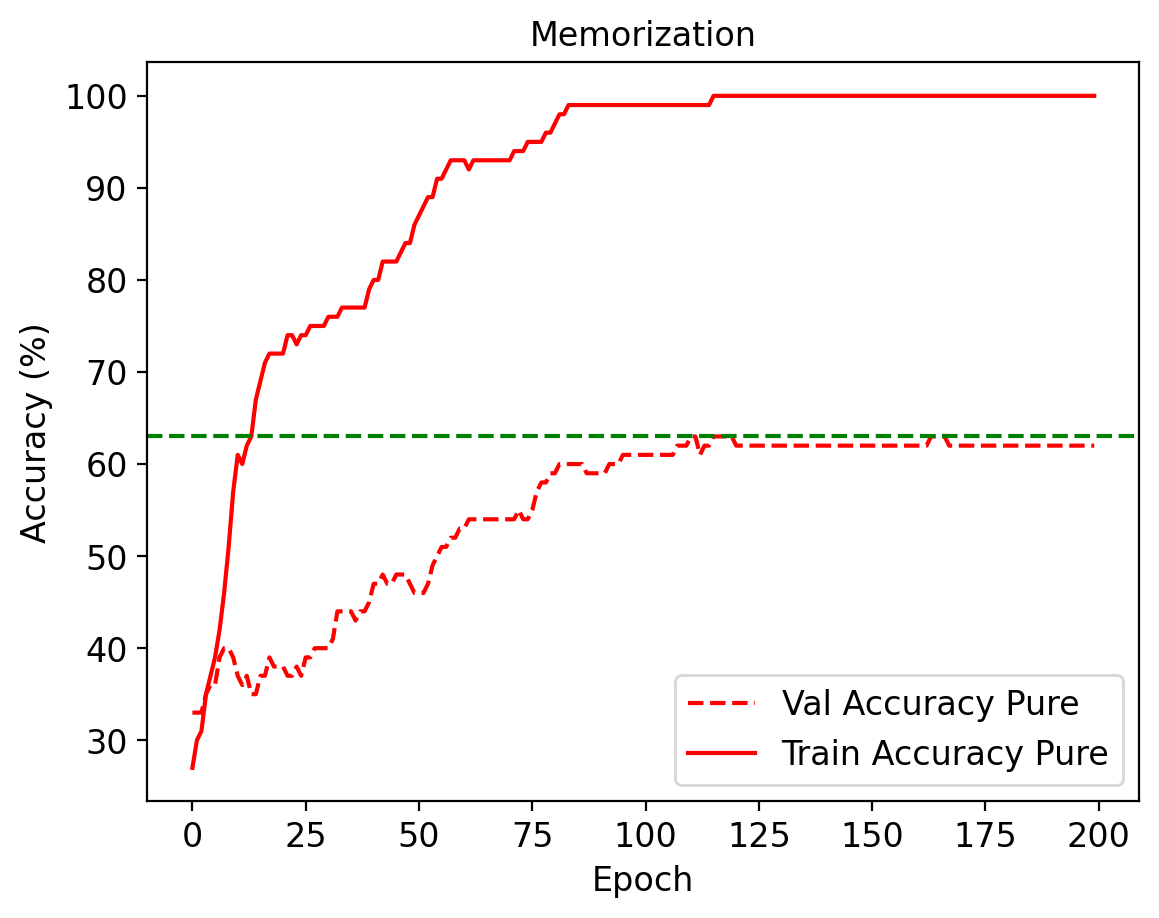

In [83]:
start_time = time.time()
val_acc_pure, train_acc_pure, _, model ,_ = main(args,model,train_loader,val_loader,img_test_dataset)
end_time = time.time()

print("Time to memorize the dataset:",end_time - start_time)

##Train and Test accuracy plot

plt.plot(val_acc_pure,label='Val Accuracy Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train Accuracy Pure',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_pure),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

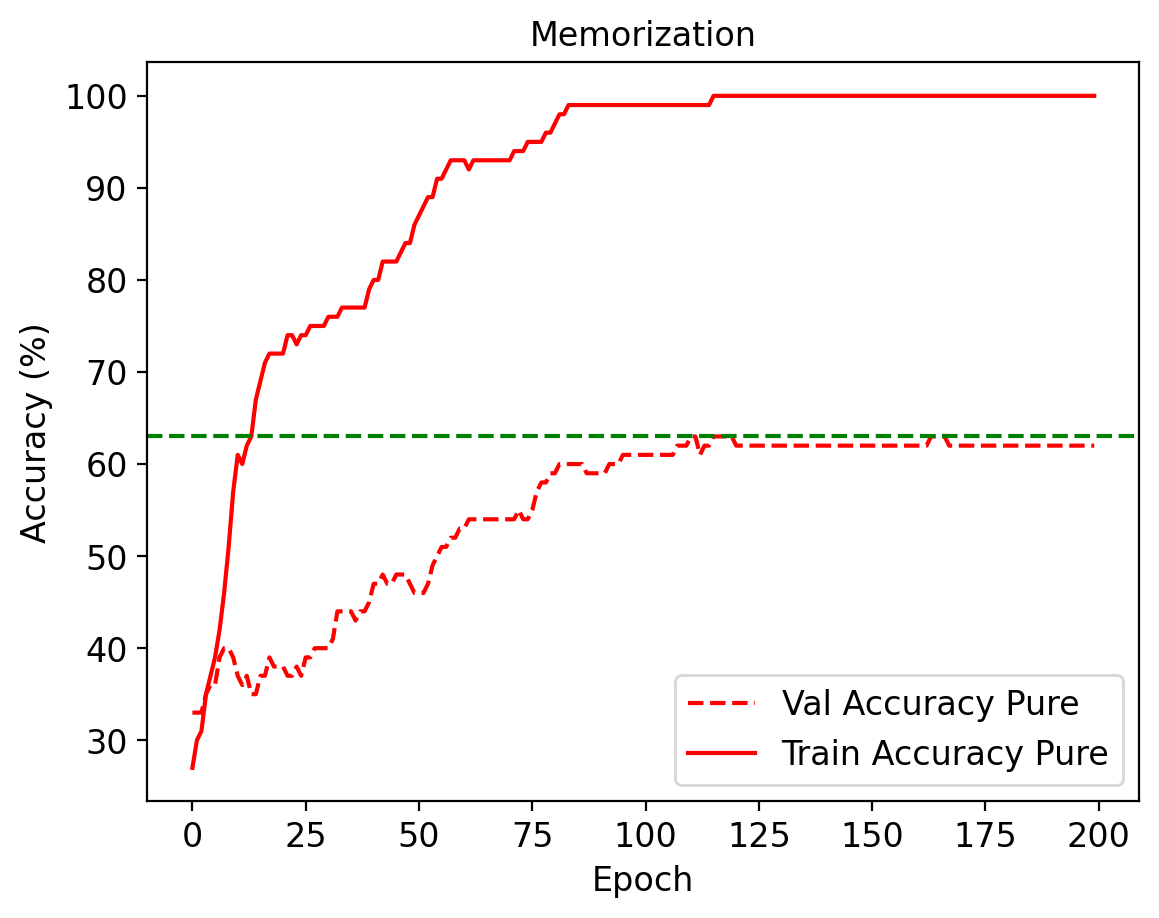

In [84]:
plt.plot(val_acc_pure,label='Val Accuracy Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train Accuracy Pure',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_pure),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Data Visualizer
Before we proceed to train the model on a data with random labels, let us visualize and verify for ourselves if the data is random or not. Here, we have classes = ("cat","dog","wild"). 


The image belongs to : dog


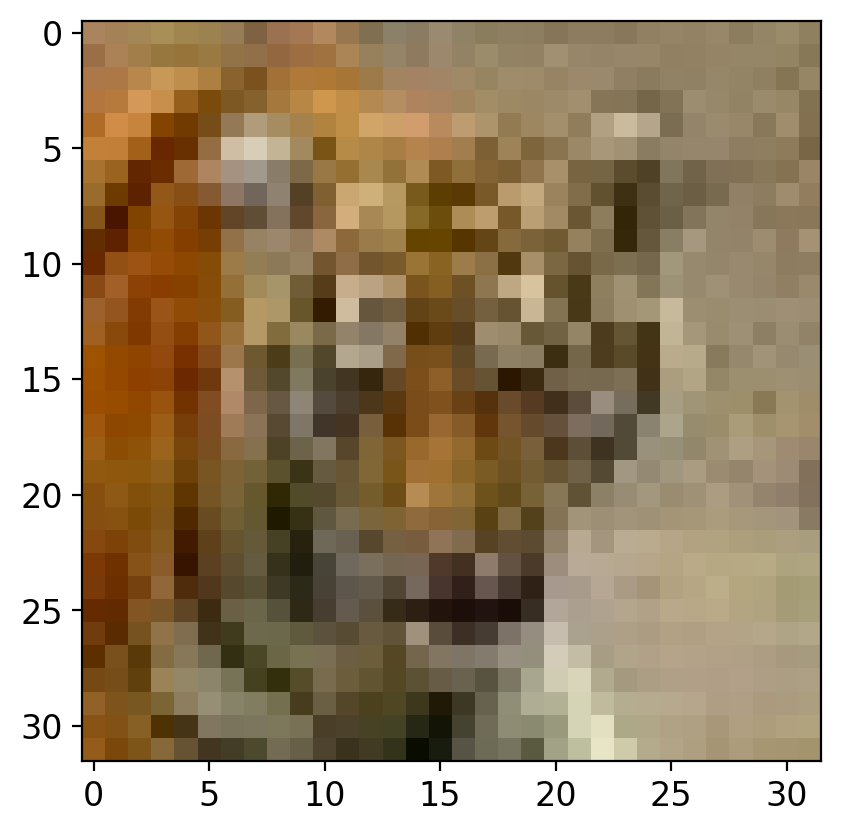

In [85]:
def Visualize_data(dataloader):
  """
    Inputs: Pytorch Dataloader
    It visualizes the images in the dataset and the classes they belong to.
  """

  for idx,(data,label) in enumerate(dataloader):

    plt.figure(idx)
    #Choose the datapoint you would like to visualize
    index = 22
    
    #choose that datapoint using index and permute the dimensions and bring the pixel values between [0,1]
    data = data[index].permute(1,2,0)* torch.tensor([0.5,0.5,0.5]) + torch.tensor([0.5,0.5,0.5])
    
    #Convert the torch tensor into numpy
    data = data.numpy()
    
    plt.imshow(data)
    image_class = classes[label[index].item()]
    print(f'The image belongs to : {image_class}')

  plt.show()
Visualize_data(rand_train_loader)


We can see that the model is mixed up.

100%|██████████| 200/200 [00:20<00:00,  9.90it/s]


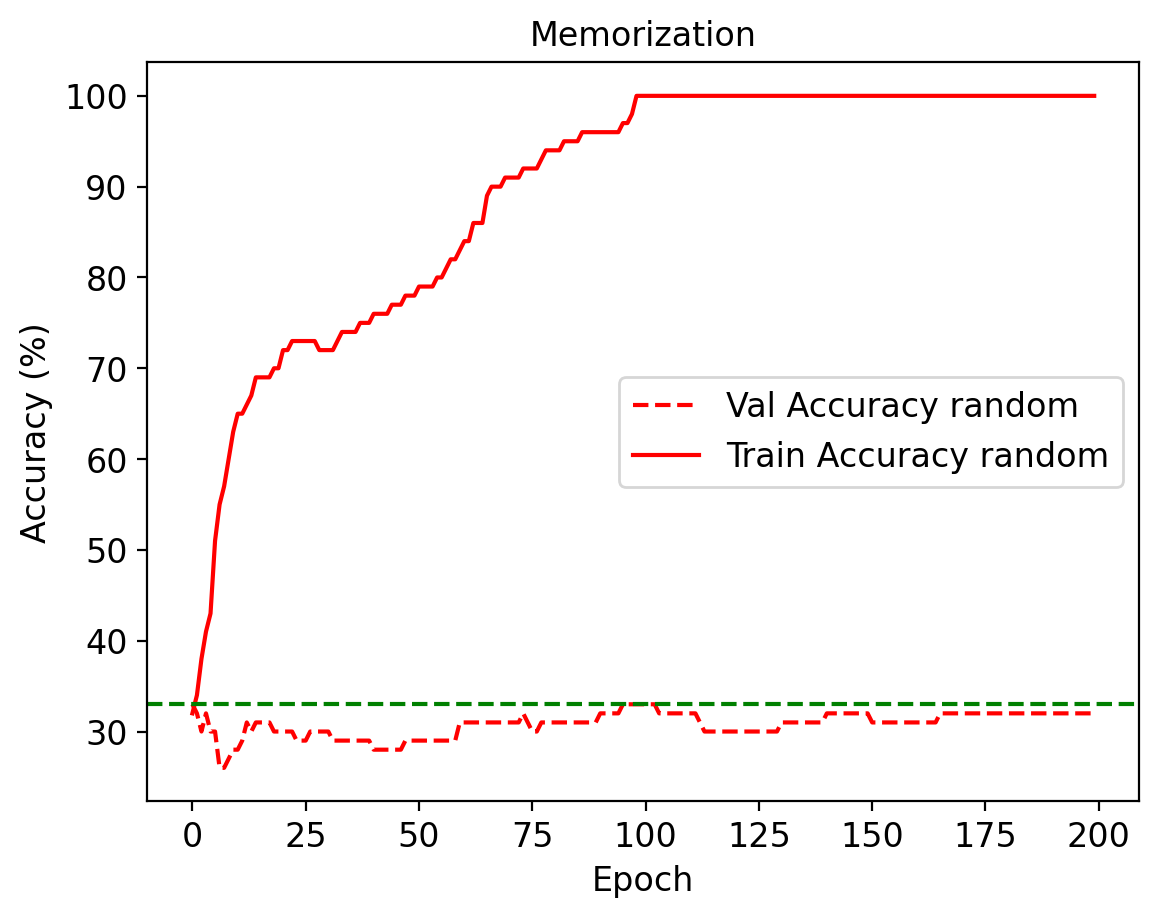

In [86]:
##Here we have 100 completely shuffled train data.
args = {'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False
        }

acc_dict = {}
model = Big_Animal_Net()


val_acc_random, train_acc_random, _,model,_ = main(args,model,rand_train_loader,val_loader,img_test_dataset)

##Train and Test accuracy plot

plt.plot(val_acc_random,label='Val Accuracy random',c='red',ls = 'dashed')
plt.plot(train_acc_random,label='Train Accuracy random',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_random),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Finally lets train on a partially shuffled dataset where 15% of the labels are noisy.

100%|██████████| 200/200 [00:20<00:00, 10.00it/s]


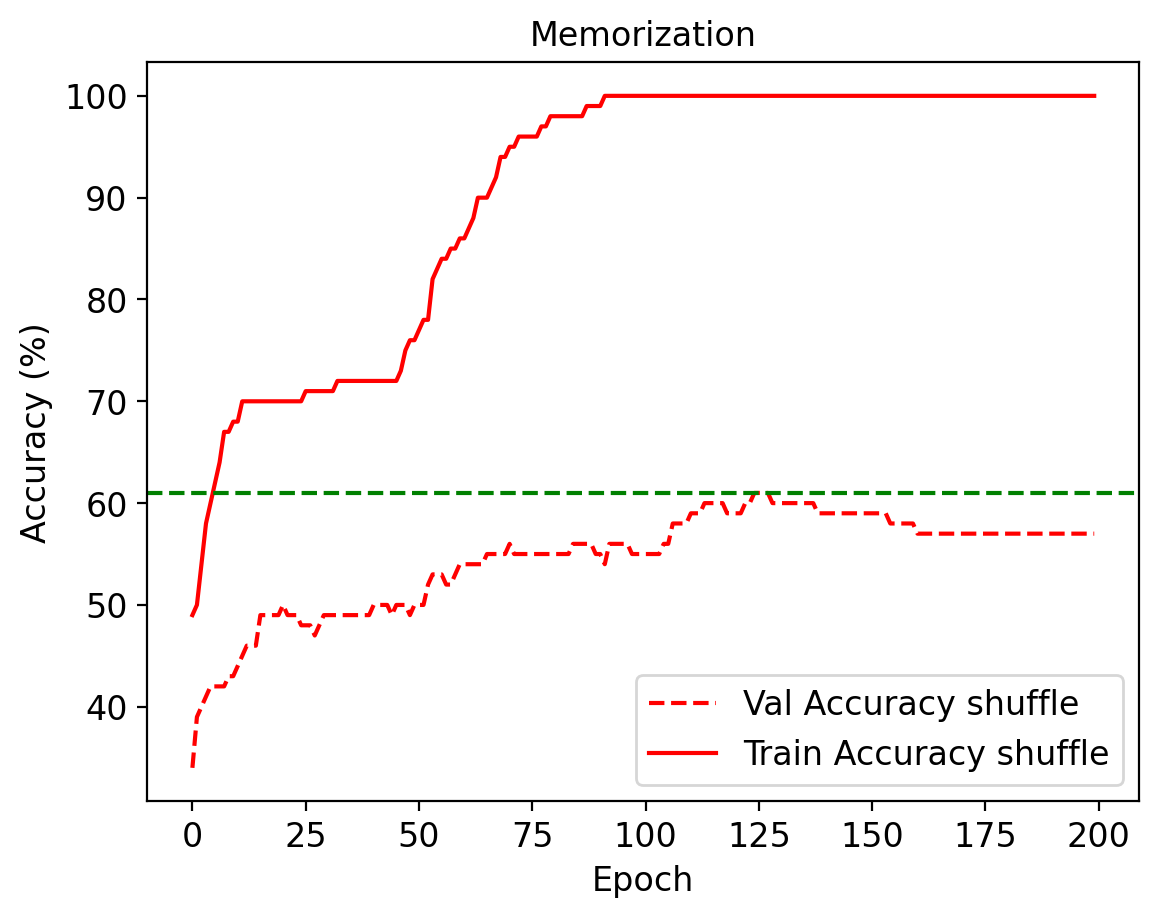

In [87]:
##Here we have 100 partially shuffled train data.
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False,
        }

acc_dict = {}
model = Big_Animal_Net()


val_acc_shuffle, train_acc_shuffle, _,_,_ = main(args,model,partial_rand_train_loader,val_loader,img_test_dataset)

#train and test acc plot
plt.plot(val_acc_shuffle,label='Val Accuracy shuffle',c='red',ls = 'dashed')
plt.plot(train_acc_shuffle,label='Train Accuracy shuffle',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_shuffle),c = 'green',ls = 'dashed')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

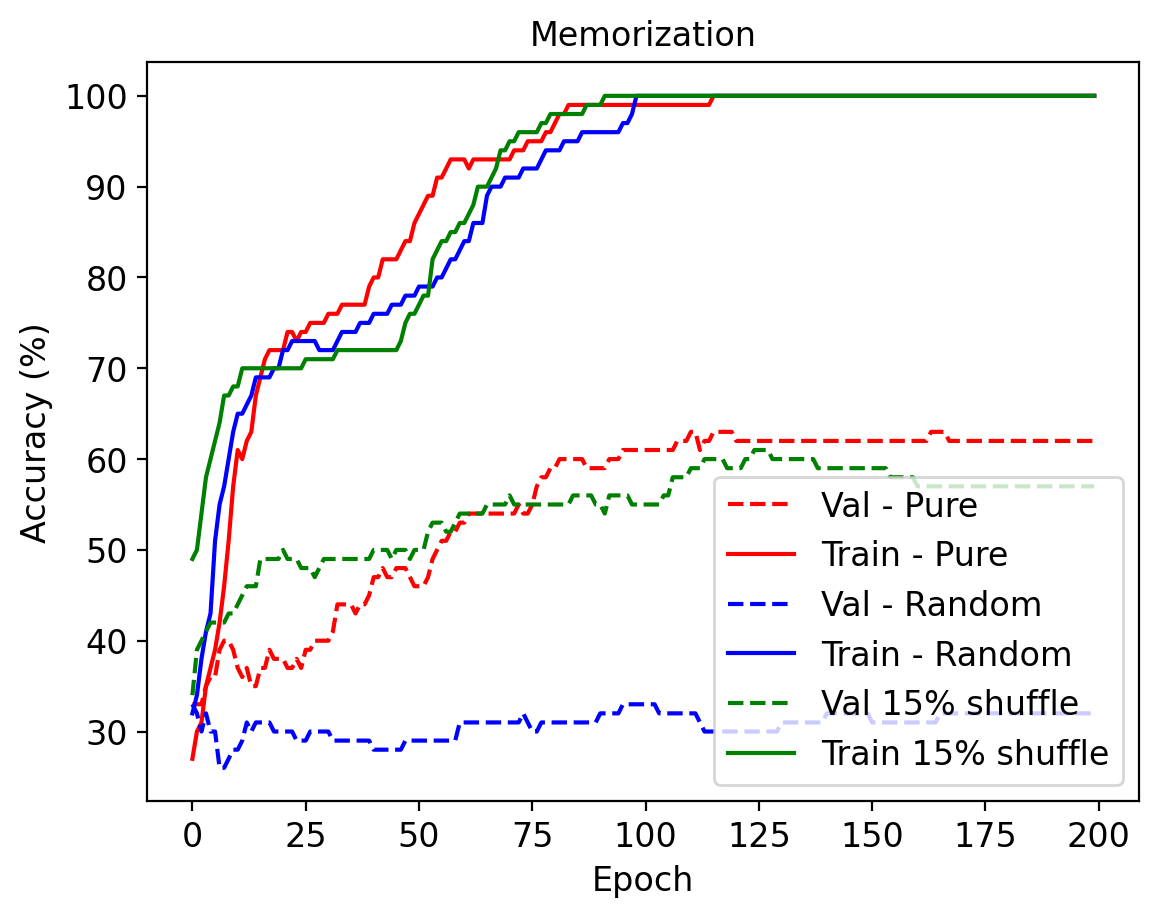

In [88]:
plt.plot(val_acc_pure,label='Val - Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train - Pure',c='red',ls = 'solid')
plt.plot(val_acc_random,label='Val - Random',c='blue',ls = 'dashed')
plt.plot(train_acc_random,label='Train - Random',c='blue',ls = 'solid')
plt.plot(val_acc_shuffle,label='Val 15% shuffle',c='green',ls = 'dashed')
plt.plot(train_acc_shuffle,label='Train 15% shuffle',c='green',ls = 'solid')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Given that the NN fit/memorize the training data perfectly, Do you think it generalizes well? What makes you think it does or doesn't?


Isn't it supprising to see that the NN was able to acheive 100% train accuracy on randomly shuffled labels. This is one of the reasons why training accuracy is not a good indicator of model performance. 

Also it is interesting to note that sometimes the model trained on slightly shuffled data does slightly better than the one trained on pure data.  

##Early Stopping



Now that we have established that the validation accuracy reaches the peak well before the model overfits we want to somehow stop the training early. You should have also observed from the above plots that the train/test loss on real data is not very smooth and hence you might guess that the choice of epoch can play a very large role on the val/test accuracy of your model. 

Early stopping is a way to end training when the validation accuracies do not increase for over a certain number of epochs. Though this makes sure that we do not overfit on the train data we still haven't solved the problem of local variance. To overcome this we also save the best model based on the val loss/accuracy for use on test dataset.

![Overfitting](https://images.deepai.org/glossary-terms/early-stopping-machine-learning-5422207.jpg)

The following function figures out the epoch best suited for stopping early.

In [89]:
def early_stopping_main(args,model,train_loader,val_loader,test_data):

    """
        Inputs: 
            Model: Pytorch model
            Loaders: Pytorch Train and Validation loaders
        The function trains the model and terminates the training based on the early stopping criterion.
    """

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

    patience = 20
    wait = 0

    best_acc  = 0.0
    best_epoch = 0

    val_acc_list, train_acc_list = [], []
    for epoch in tqdm(range(args['epochs'])):
        train(args, model, device, train_loader, optimizer, epoch)
        train_acc = test(model,device,train_loader, 'Train')
        val_acc = test(model,device,val_loader, 'Val')
        if (val_acc > best_acc):
          best_acc = val_acc
          best_epoch = epoch
          best_model = copy.deepcopy(model)
          wait = 0
        else:
          wait += 1
        if (wait > patience):
          print('early stopped on epoch:',epoch)
          break
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    return val_acc_list, train_acc_list, best_model, best_epoch


In [90]:
args = {'epochs': 200,
        'lr': 5e-4,
        'momentum': 0.99,
        'no_cuda': False,
        }

acc_dict = {}
model = Animal_Net()

val_acc_pure, train_acc_pure,_,_ ,best_epoch = main(args,model,train_loader,val_loader,img_test_dataset)

model = Animal_Net()
val_acc_earlystop, train_acc_earlystop,_,best_epoch = early_stopping_main(args,model,train_loader,val_loader,img_test_dataset)

print("Maximum Validation Accuracy is reached at epoch:%2d"%(best_epoch))

 60%|█████▉    | 119/200 [00:11<00:07, 10.35it/s]

early stopped on epoch: 119
Maximum Validation Accuracy is reached at epoch:98


Do you think Early stopping can be harmful for the training of your network?Discuss among your pod why or why not?

##L1/LASSO Regularization

Some of you might have already come across L1 and L2 regularization before in other courses. L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term.

***Cost function = Loss (say, binary cross entropy) + Regularization term***

Due to the addition of this regularization term, the values of parameters decrease because it assumes that a neural network with a lower parameter values leads to simpler models. Therefore, it will also reduce overfitting to quite an extent.



L1 Regularization uses a Regularization Function which is the sum of the absolute value of all the weights in DLN, resulting in the following loss function ( L  is the usual Cross Entropy loss):

\begin{equation}
L_R=L+λ∑|w^{(r)}_{ij}|
\end{equation}

At a high level L1 Regularization is similar to L2 Regularization since it leads to smaller weights (you will see the analogy in the next subsection). It results in the following weight update equation when using Stochastic Gradient Descent (where  sgn  is the sign function, such that  sgn(w)=+1  if  w>0 ,  sgn(w)=−1  if  $w<0$ , and sgn(0)=0 ):

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−ηλsgn(w^{(r)}_{ij})−η\frac{\partial L}{\partial w_{ij}^{r}} 
\end{equation}

In the code which follows we will create an unregularised model, a L1 model, L2 model, and an elastic model and compare the results.

##Unregularized Model

In [91]:
# Dataloaders for Regularization

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

#Splitting dataset
reg_train_data, reg_val_data,_ = torch.utils.data.random_split(img_dataset, [30,100,14500])

#Creating train_loader and Val_loader
reg_train_loader = torch.utils.data.DataLoader(reg_train_data,batch_size=batch_size,worker_init_fn=seed_worker)
reg_val_loader = torch.utils.data.DataLoader(reg_val_data,batch_size=1000,worker_init_fn=seed_worker)


Now let's train a model without any regularization and keep it aside as our bencmark for this section.

100%|██████████| 150/150 [00:08<00:00, 17.96it/s]


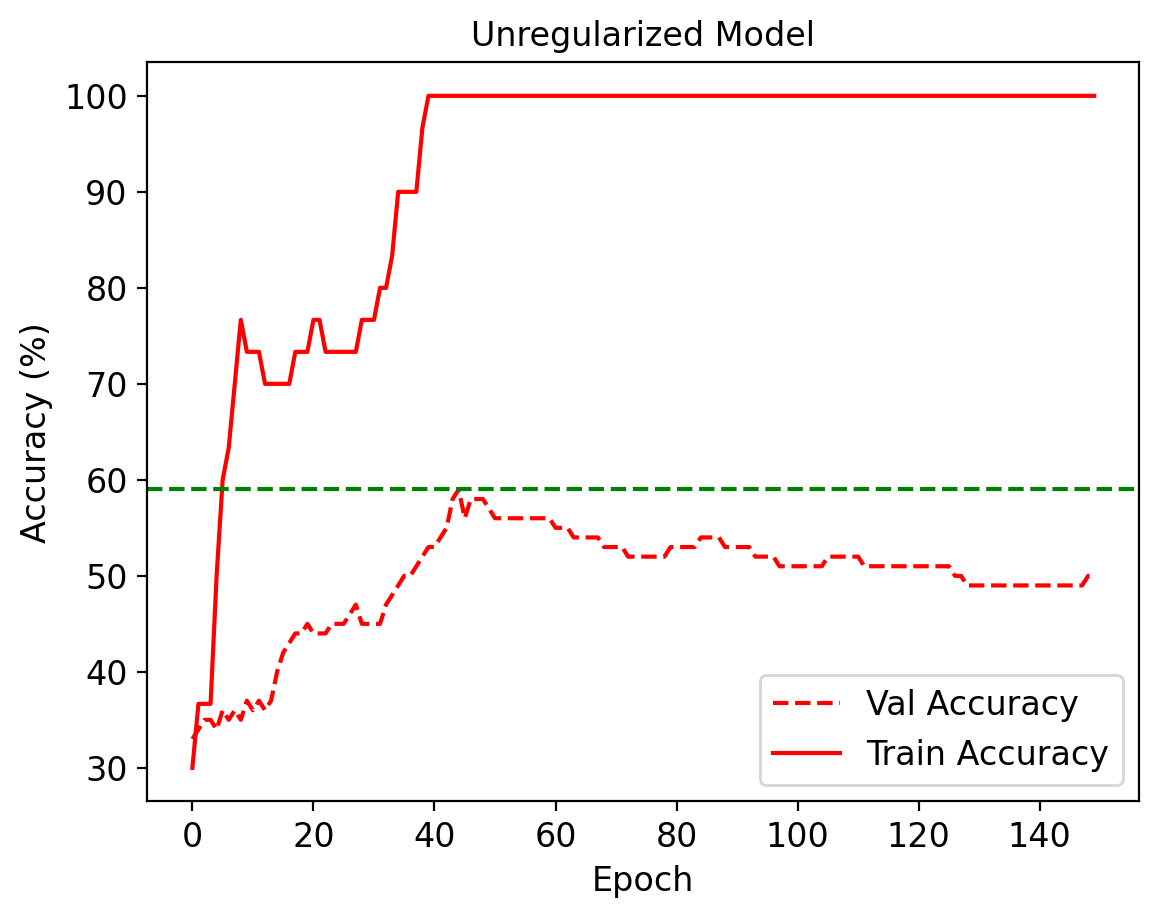

maximum Validation Accuracy reached:59.000000


In [92]:
args = {'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        }

acc_dict = {}
model = Animal_Net()

val_acc_unreg, train_acc_unreg,param_norm_unreg,_ ,_ = main(args, model, reg_train_loader, reg_val_loader, img_test_dataset)

##Train and Test accuracy plot

plt.plot(val_acc_unreg,label='Val Accuracy',c='red',ls = 'dashed')
plt.plot(train_acc_unreg,label='Train Accuracy',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_unreg),c = 'green',ls = 'dashed')
plt.title('Unregularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_unreg))

In [93]:
def l1_reg(model):
  """
    Inputs: Pytorch model 
    This function calculates the l1 norm of the all the tensors in the model
  """
  l1 = 0

  for param in model.parameters():
    l1 += torch.sum(torch.abs(param))

  return l1


In [94]:

net = nn.Linear(20,20)
print(f'L1 norm of the model: {l1_reg(net)}')

L1 norm of the model: 44.51029968261719


In [95]:
# here is an example of model setting. But if you don't want to use their dataset, you may want to rewrite this part.
class Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(104)
        super(Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## Lambda Parameter for Regularisation

You can see below we have a new argument in the argument dict - the lambda value. This is the same lambda we saw in the L1 expression above, and we will see it again with the other regularisation methods. Lamda values often range from 0-5. We start with a value of 0.1, and the ideal way to identify the lambda value is to do a grid optimisation (i.e run it for various values and see what works best). 1 is considered a large lambda value, and often we search between [0.1, 0.2 ... 0.9, 1, 2, 5].

Here is a useful Stackoverflow link with information related to the topic - [calculating lambda value](https://stackoverflow.com/questions/12182063/how-to-calculate-the-regularization-parameter-in-linear-regression).

100%|██████████| 150/150 [00:08<00:00, 18.01it/s]


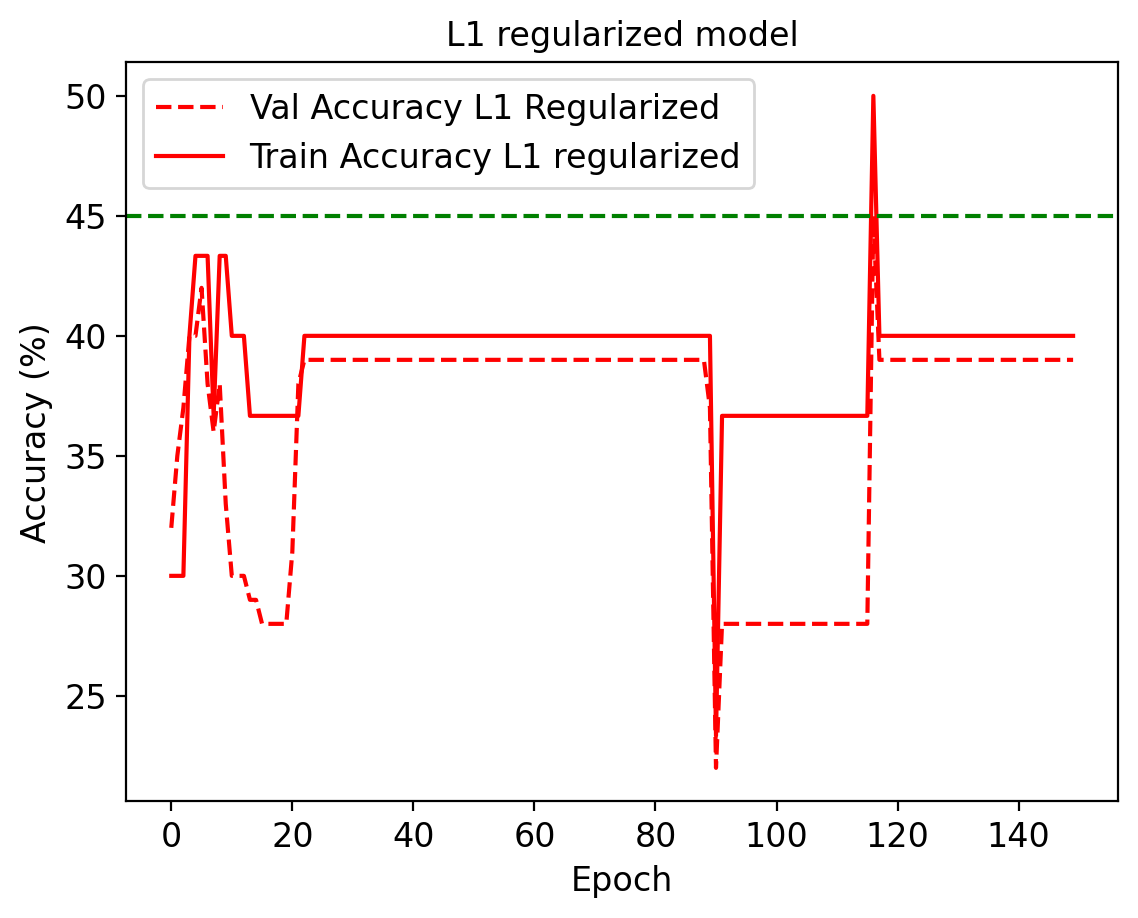

maximum Validation Accuracy reached:45.000000


In [96]:
args = {'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        'lambda': 0.1
        }

acc_dict = {}
model = Animal_Net()

val_acc_l1reg, train_acc_l1reg,param_norm_l1reg,_,_ = main(args, model, reg_train_loader, reg_val_loader, img_test_dataset, reg_function1=l1_reg)

##Train and Test accuracy plot

plt.plot(val_acc_l1reg,label='Val Accuracy L1 Regularized',c='red',ls = 'dashed')
plt.plot(train_acc_l1reg,label='Train Accuracy L1 regularized',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l1reg),c = 'green',ls = 'dashed')
plt.title('L1 regularized model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_l1reg))

##L2 / Ridge Regularization

L2 Regularization is a commonly used technique in ML systems is also sometimes referred to as “Weight Decay”. It works by adding a quadratic term to the Cross Entropy Loss Function  L , called the Regularization Term, which results in a new Loss Function  LR  given by:

\begin{equation}
LR=L+λ∑(w^{(r)}_{ij})^2
\end{equation}

In order to get further insight into L2 Regularization, we investigate its effect on the Gradient Descent based update equations for the weight and bias parameters. Taking the derivative on both sides of the above equation, we obtain

\begin{equation}
\frac{\partial L_r}{\partial w^{(r)}_{ij}}=\frac{\partial L}{\partial w^{(r)}_{ij}}+λw^{(r)}_{ij}
\end{equation}
Thus the weight update rule becomes:

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−η\frac{\partial L}{\partial W^{(r)}_{ij}}−ηλw^{(r)}_{ij}=(1−ηλ)w^{(r)}_{ij}−η\frac{\partial L}{\partial w^{(r)}_{ij}}
\end{equation}

where, $\eta$ is learning rate.

In [97]:
def l2_reg(model):

  """
    Inputs: Pytorch model 
    This function calculates the l2 norm of the all the tensors in the model
  """

  l2 = 0.0

  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)
  
  return l2

net = nn.Linear(20,20)
print(f'L2 norm of the model: {l2_reg(net)}')

L2 norm of the model: 6.491175174713135


here they just run a L1 norm model and L2 norm model and see whether the accuracy increases (and visualize them)

100%|██████████| 150/150 [00:15<00:00,  9.86it/s]


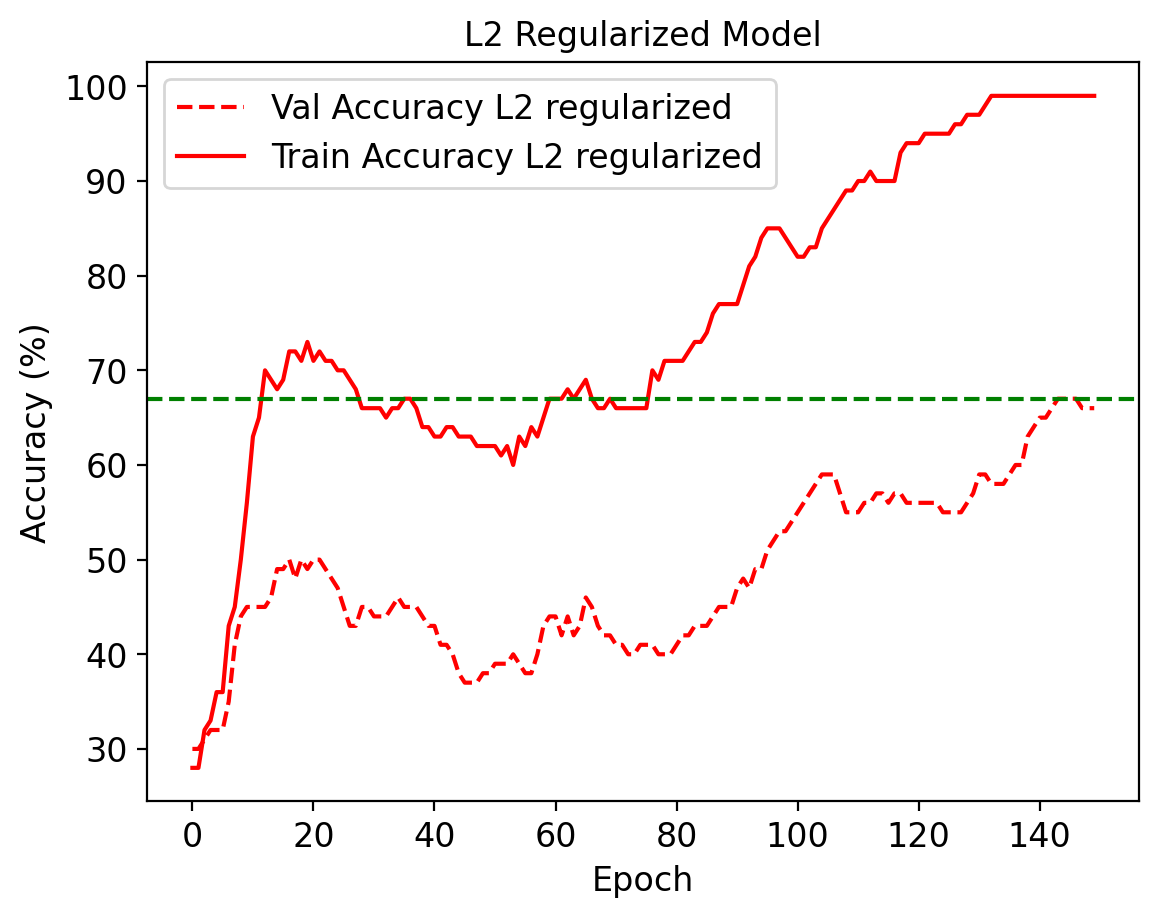

maximum Validation Accuracy reached:67.000000


In [98]:
args = {'test_batch_size': 1000,
        'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        'lambda': 0.1
        }

acc_dict = {}
model = Animal_Net()

val_acc_l2reg, train_acc_l2reg,param_norm_l2reg,model ,_ = main(args,model,train_loader,val_loader,img_test_dataset,reg_function1=l2_reg)

##Train and Test accuracy plot

plt.plot(val_acc_l2reg,label='Val Accuracy L2 regularized',c='red',ls = 'dashed')
plt.plot(train_acc_l2reg,label='Train Accuracy L2 regularized',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l2reg),c = 'green',ls = 'dashed')
plt.title('L2 Regularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_l2reg))

##L1+L2 / Elastic net regularization

Elastic Net regularization uses both L1 and L2 weights for regression. The loss function becomes:

\begin{equation}
LR=L+ λ_{1}∑|w^{(r)}_{ij}| + λ_{2}∑(w^{(r)}_{ij})^2
\end{equation}

The weights updated equation then becomes:

\begin{equation}
w^{(r)}_{ij}←(1−ηλ_{2})w^{(r)}_{ij}−ηλ_{1}sgn(w^{(r)}_{ij})−η\frac{\partial L}{\partial w_{ij}^{r}} 
\end{equation}

where, $\eta$ is learning rate.

100%|██████████| 150/150 [00:15<00:00,  9.80it/s]


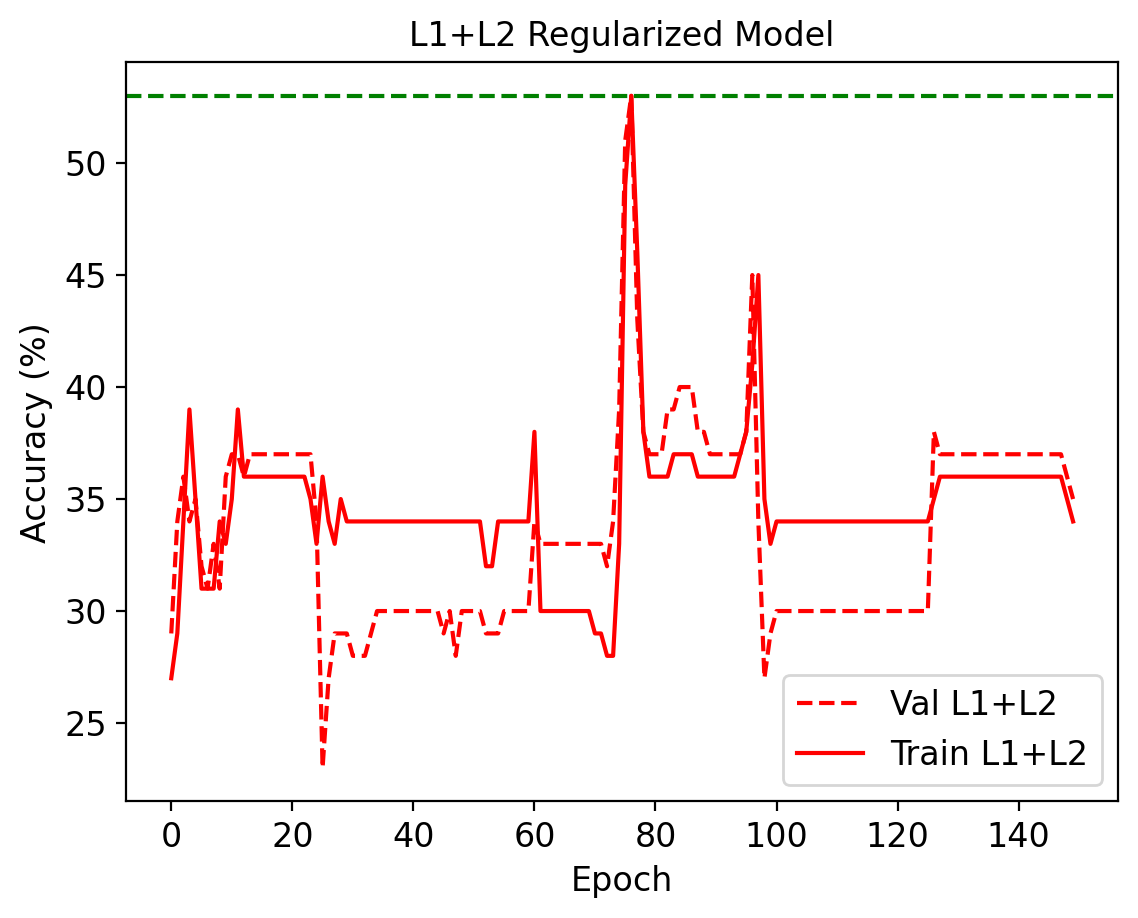

maximum Validation Accuracy reached:53.000000


In [99]:
args = {'epochs': 150,
        'lr': 5e-3,
        'momentum': 0.99,
        'no_cuda': False,
        'lambda1':0.1,
        'lambda2':0.1
        }

acc_dict = {}
model = Animal_Net()

val_acc_l1l2reg, train_acc_l1l2reg,param_norm_l1l2reg,model ,_ = main(args,model,train_loader,val_loader,img_test_dataset,reg_function1=l1_reg,reg_function2=l2_reg)

##Train and Test accuracy plot

plt.plot(val_acc_l1l2reg,label='Val L1+L2',c='red',ls = 'dashed')
plt.plot(train_acc_l1l2reg,label='Train L1+L2',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l1l2reg),c = 'green',ls = 'dashed')
plt.title('L1+L2 Regularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('maximum Validation Accuracy reached:%f'%max(val_acc_l1l2reg))

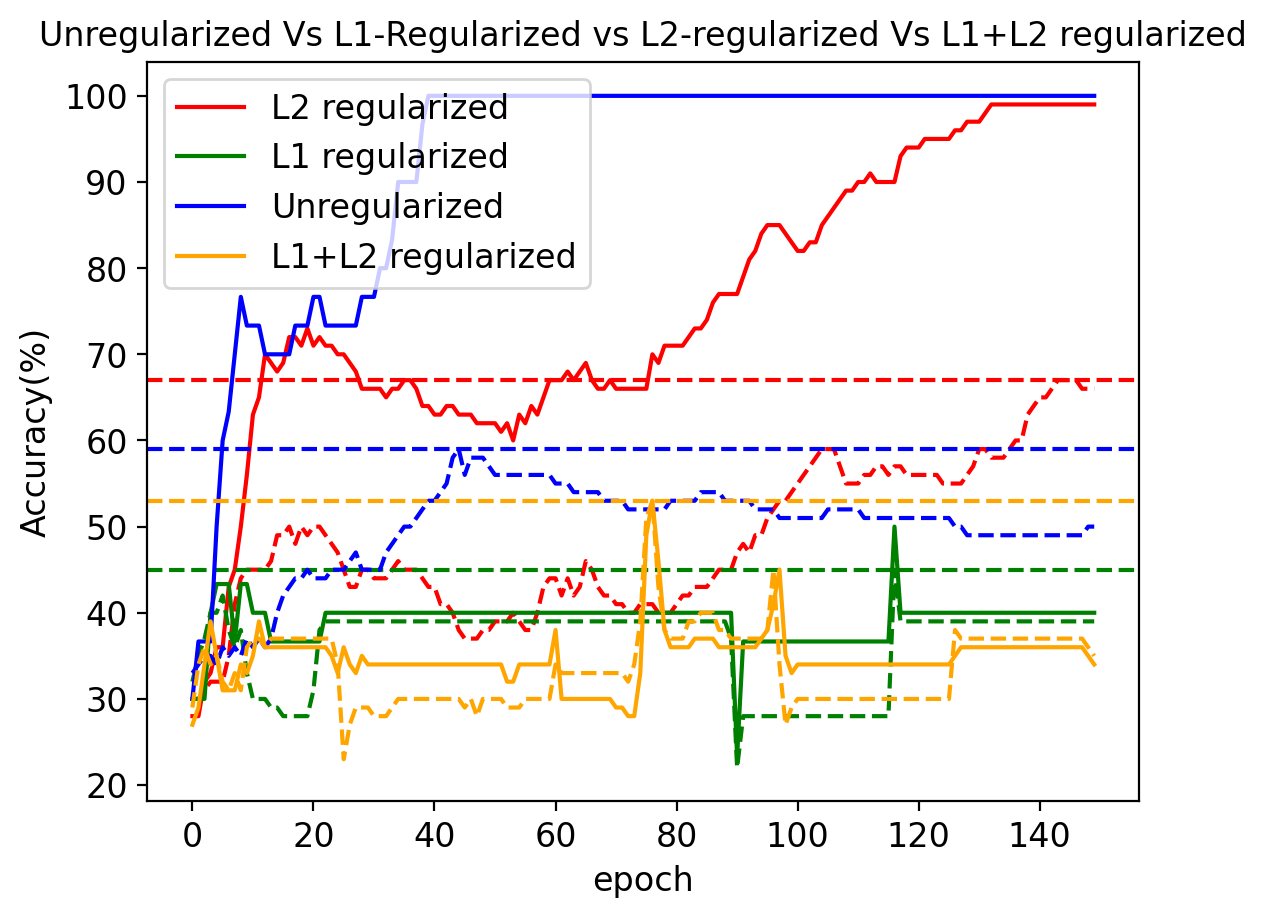

In [100]:
plt.plot(val_acc_l2reg,c='red',ls = 'dashed')
plt.plot(train_acc_l2reg,label='L2 regularized',c='red',ls = 'solid')
plt.axhline(y=max(val_acc_l2reg),c = 'red',ls = 'dashed')
plt.plot(val_acc_l1reg,c='green',ls = 'dashed')
plt.plot(train_acc_l1reg,label='L1 regularized',c='green',ls = 'solid')
plt.axhline(y=max(val_acc_l1reg),c = 'green',ls = 'dashed')
plt.plot(val_acc_unreg,c='blue',ls = 'dashed')
plt.plot(train_acc_unreg,label='Unregularized',c='blue',ls = 'solid')
plt.axhline(y=max(val_acc_unreg),c = 'blue',ls = 'dashed')
plt.plot(val_acc_l1l2reg,c='orange',ls = 'dashed')
plt.plot(train_acc_l1l2reg,label='L1+L2 regularized',c='orange',ls = 'solid')
plt.axhline(y=max(val_acc_l1l2reg),c = 'orange',ls = 'dashed')

plt.title('Unregularized Vs L1-Regularized vs L2-regularized Vs L1+L2 regularized')
plt.xlabel('epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()

### Alternative ways to implement Regularisation in PyTorch

It is also possible to set up L2 regularisation (weight decay) by just using the ```weight_decay``` parameter in your optimisation method. Link to [optimisers documentation](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), and [discussion on L1 and L2 implementations on stackoverflow](https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch).

### Regularisation with Keras

[Keras documentation for layer regularizers](https://keras.io/api/layers/regularizers/)

[How to use weight decay (L2 reg) with Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/)

## Dropout


### Dropout Implementation Caveats: 


*  Dropout is used only during training, during testing the complete model weights are used and hence it is important to use model.eval() before testing the model. 

* Dropout reduces the capacity of the model during training and hence as a general practice wider networks are used when using dropout. If you are using a dropout with a random probability of 0.5 then you might want to double the number of hidden neurons in that layer.

Now, lets see how Dropout fares on the Animal Faces Dataset. We first modify the existing model to include dropouts and then train the model.

In [101]:
##Network Class - Animal Faces
class Animal_Net_Dropout(nn.Module):
    def __init__(self):
        torch.manual_seed(32)
        super(Animal_Net_Dropout, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 248)
        self.fc2 = nn.Linear(248, 210)
        self.fc3 = nn.Linear(210, 3)
        self.dropout1 = nn.Dropout(p = 0.5)
        self.dropout2 = nn.Dropout(p = 0.3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.dropout1(self.fc1(x)))
        x =F.leaky_relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

100%|██████████| 200/200 [00:20<00:00,  9.67it/s]


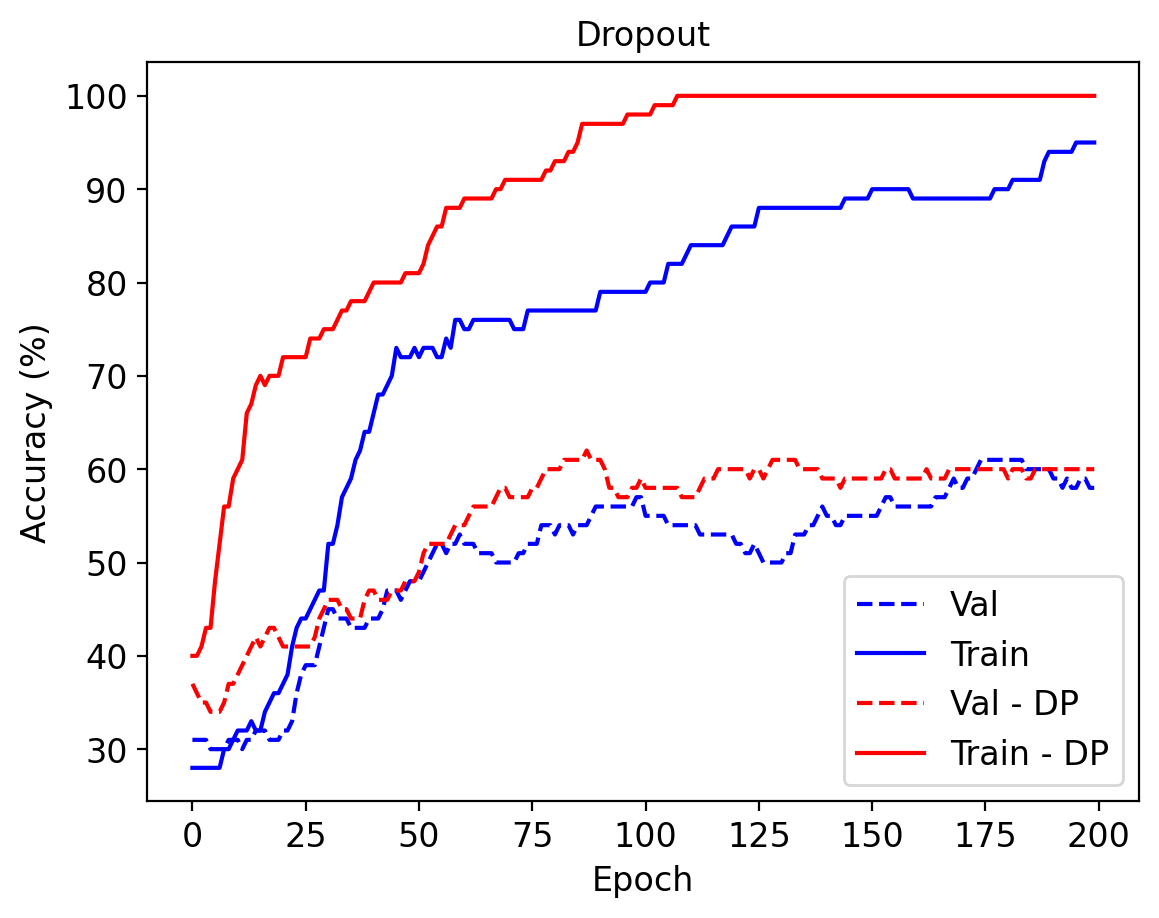

In [102]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'batch_size': 32,
        'momentum': 0.9,
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

acc_dict = {}
model = Animal_Net_Dropout()

val_acc_dropout, train_acc_dropout, _, model ,_ = main(args,model,train_loader,val_loader,img_test_dataset)

##Train and Test accuracy plot

plt.plot(val_acc_pure,label='Val',c='blue',ls = 'dashed')
plt.plot(train_acc_pure,label='Train',c='blue',ls = 'solid')
plt.plot(val_acc_dropout,label='Val - DP',c='red',ls = 'dashed')
plt.plot(train_acc_dropout,label='Train - DP',c='red',ls = 'solid')
plt.title('Dropout')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

When do you think dropouts can perform bad and do you think their placement within a model matters?

### Dropout for Keras

We saw in the last tutorial how we can use dropout for Keras - similar to PyTorch, it is just adding a layer in your model.

[Keras Documentation](https://keras.io/api/layers/regularization_layers/dropout)

[Blog post on Dropout with Keras](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

## Data Augmentation


We will explore the effects of Data Augmentation on regularization. Here regularization is acheived by adding noise into training data after every epoch.

Pytorch's torchvision module provides a few inbuilt data augmentation techniques which we can use on image datasets. Some of the techniques we most frequently use are:


*   Random Crop
*   Random Rotate
*   Vertical Flip
*   Horizontal Flip



In [103]:
##Data Augmentation using transforms
new_transforms = transforms.Compose([
                                     transforms.RandomHorizontalFlip(p=0.1),
                                     transforms.RandomVerticalFlip(p=0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=new_transforms)
#Splitting dataset
new_train_data, _,_ = torch.utils.data.random_split(img_dataset, [250,100,14280])

#Creating train_loader and Val_loader
new_train_loader = torch.utils.data.DataLoader(new_train_data,batch_size=batch_size,worker_init_fn=seed_worker)

In [104]:
args = {'epochs': 250,
        'lr': 1e-3,
        'momentum': 0.99,
        'no_cuda': False,
        }



100%|██████████| 250/250 [00:25<00:00,  9.71it/s]


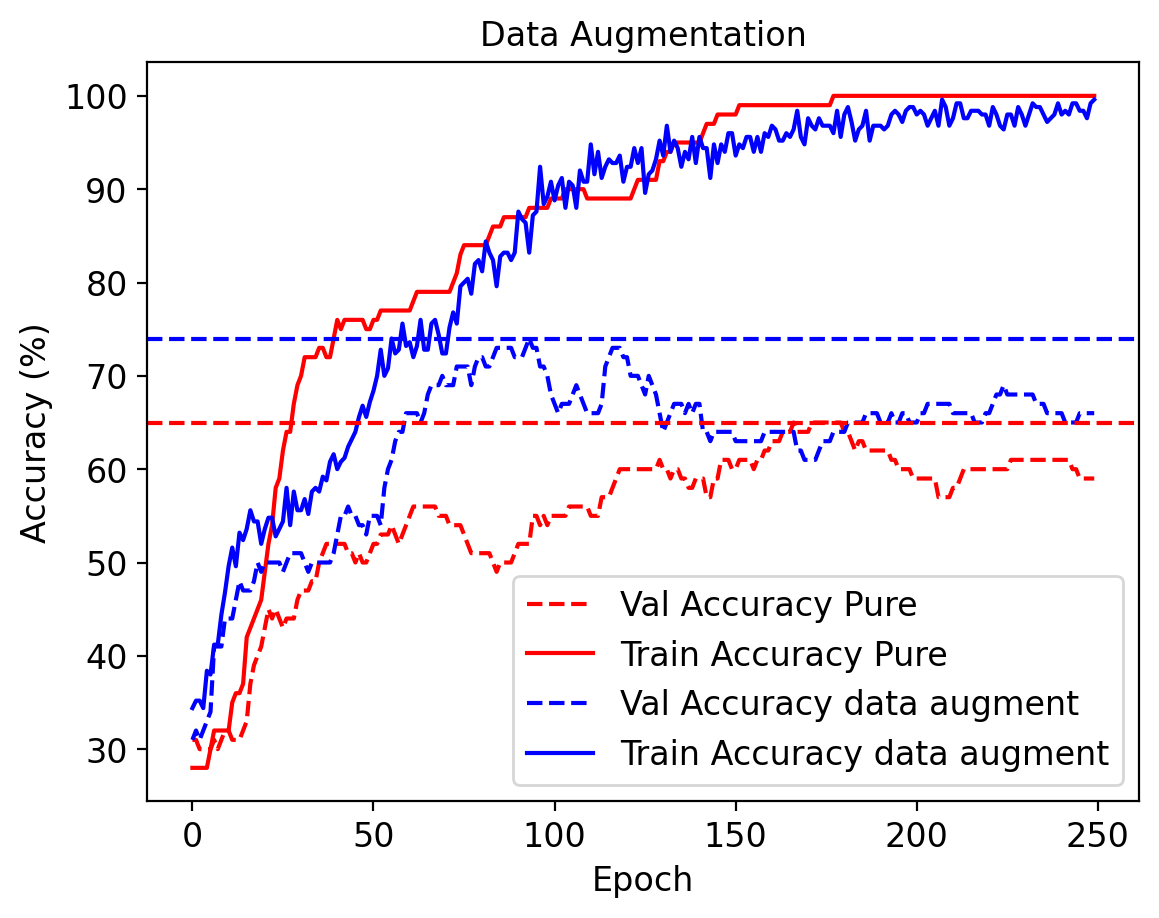

In [105]:

acc_dict = {}
model = Animal_Net()

val_acc_dataaug, train_acc_dataaug, param_norm_datadug, _ ,_ = main(args,model,new_train_loader,val_loader,img_test_dataset)
model = Animal_Net()
val_acc_pure, train_acc_pure, param_norm_pure,_,_ = main(args,model,train_loader,val_loader,img_test_dataset)


##Train and Test accuracy plot

plt.plot(val_acc_pure,label='Val Accuracy Pure',c='red',ls = 'dashed')
plt.plot(train_acc_pure,label='Train Accuracy Pure',c='red',ls = 'solid')

plt.plot(val_acc_dataaug,label='Val Accuracy data augment',c='blue',ls = 'dashed')
plt.plot(train_acc_dataaug,label='Train Accuracy data augment',c='blue',ls = 'solid')
plt.axhline(y=max(val_acc_pure),c = 'red',ls = 'dashed')
plt.axhline(y=max(val_acc_dataaug),c = 'blue',ls = 'dashed')
plt.title('Data Augmentation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [110]:
param_norm_pure = [tensor.detach().numpy() for tensor in param_norm_pure]
param_norm_datadug = [tensor.detach().numpy() for tensor in param_norm_datadug]

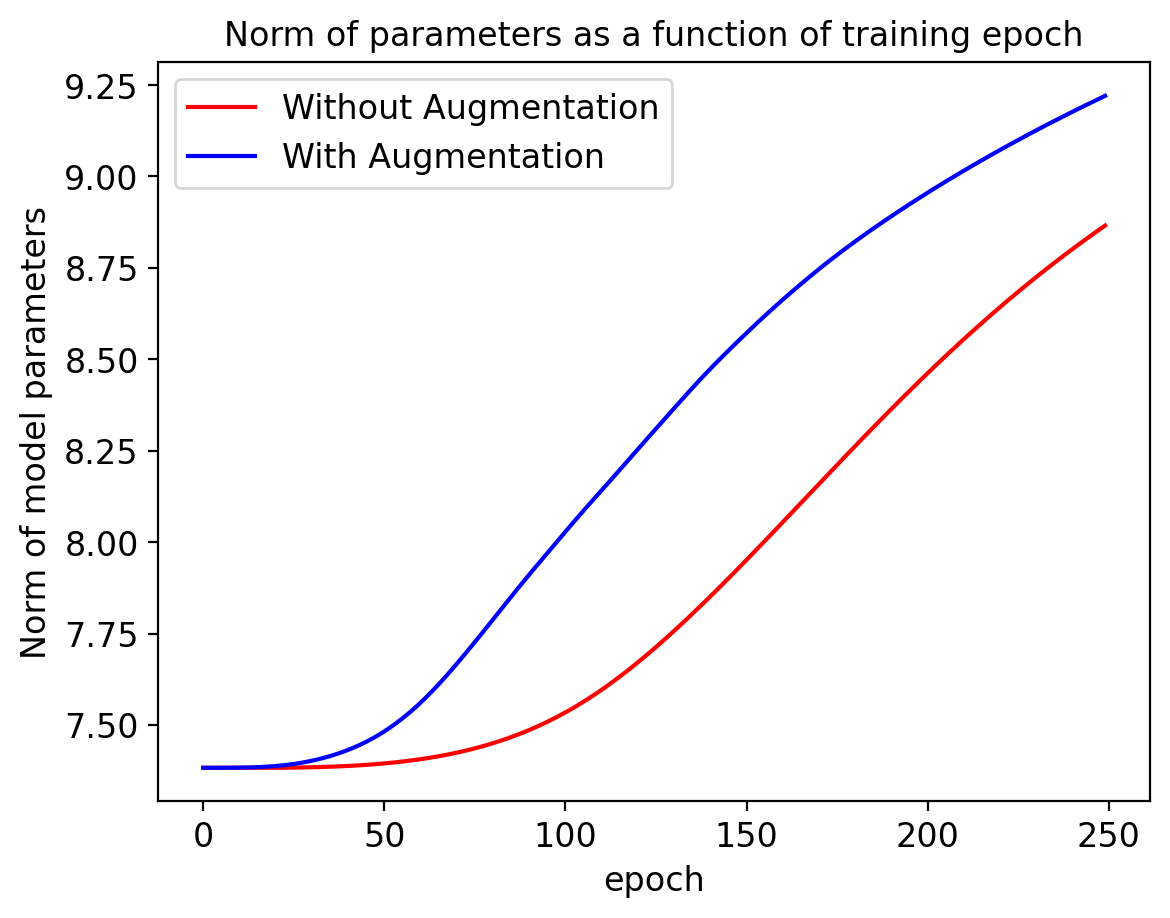

In [113]:
plt.plot(param_norm_pure,c='red',label = 'Without Augmentation')
plt.plot(param_norm_datadug,c='blue',label='With Augmentation')
plt.title('Norm of parameters as a function of training epoch')
plt.xlabel('epoch')
plt.ylabel('Norm of model parameters')
plt.legend()
plt.show()

### Data Augmentation for Keras

MixUp augmentation for image classification - https://keras.io/examples/vision/mixup/

## Batch Size
Batch size, in some cases, can also help in regularizing the models. Lower batch size leads to a noisy convergence and hence helps in converging to a broader local minima. Whereas, higher batch size lead to a smoother convergence thereby converging easily to a  deeper local minima.  This can be good or bad.

In the below blcok we will train the Animal Net model with different batch sizes and see how that is going to affect the regularization performance.

In [114]:
#@title Dataset for Batch_size
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

#Splitting dataset
reg_train_data, reg_val_data,_ = torch.utils.data.random_split(img_dataset, [250,100,14280])


In [115]:
args = {'lr': 5e-3,
        'epochs': 60,
        'momentum': 0.99,
        'no_cuda': False
        }

batch_sizes = [32,64,128]
acc_dict = {}

for i in range(len(batch_sizes)):
    model = Animal_Net()
    #Creating train_loader and Val_loader
    reg_train_loader = torch.utils.data.DataLoader(reg_train_data,batch_size=batch_sizes[i],worker_init_fn=seed_worker)
    reg_val_loader = torch.utils.data.DataLoader(reg_val_data,batch_size=1000,worker_init_fn=seed_worker)
    val_acc, train_acc,param_norm,_,_ = main(args,model,reg_train_loader,reg_val_loader,img_test_dataset)
    acc_dict['train_'+str(i)] = train_acc
    acc_dict['val_'+str(i)] = val_acc
    acc_dict['param_norm'+str(i)] = param_norm

100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


maximum accuracy for mini batchsize = 32: 67.0
maximum accuracy for mini batchsize = 64: 68.0
maximum accuracy for mini batchsize = 128: 71.0


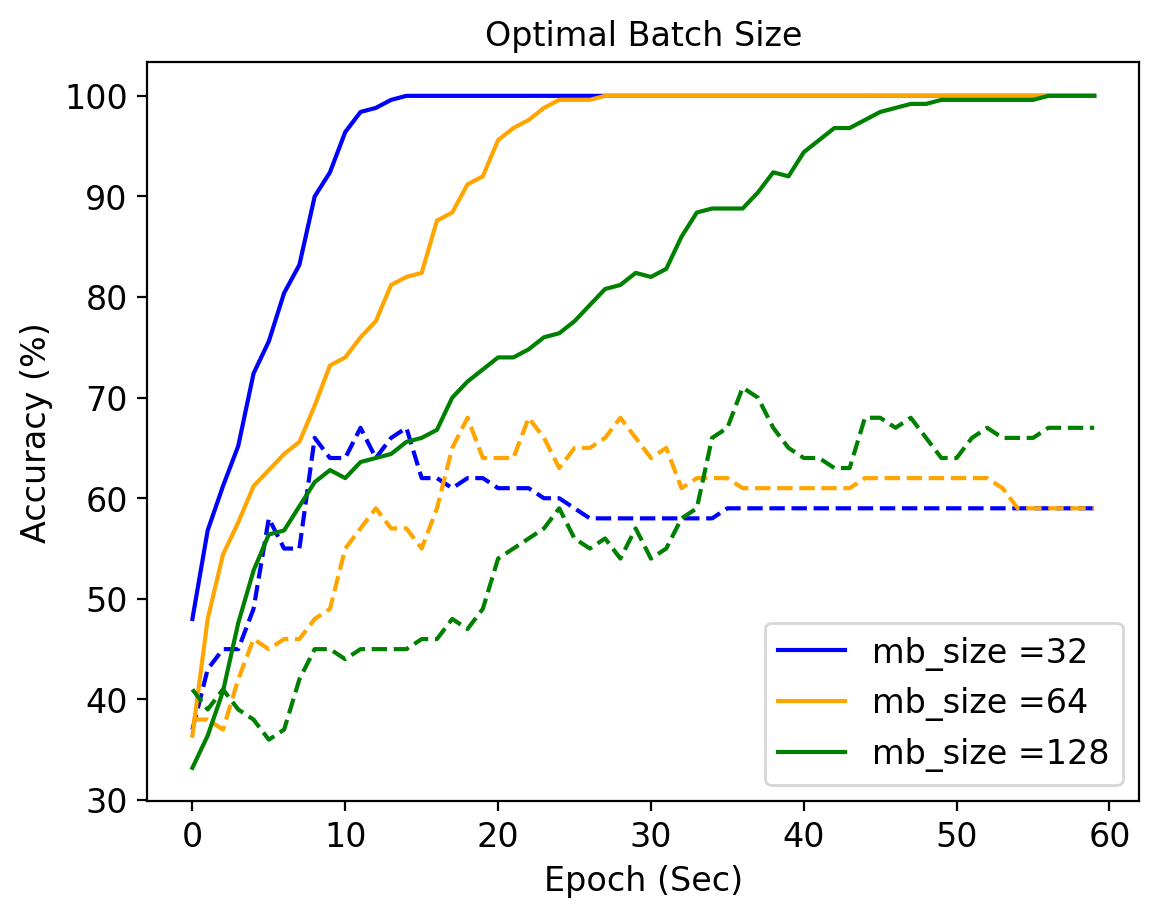

In [116]:
#Plot Train and Val curves
plt.plot(acc_dict['train_0'], label='mb_size =' + str(batch_sizes[0]), c = 'blue')
plt.plot(acc_dict['val_0'], linestyle='dashed', c = 'blue')

plt.plot(acc_dict['train_1'], label='mb_size =' + str(batch_sizes[1]), c = 'orange')
plt.plot(acc_dict['val_1'], linestyle='dashed', c = 'orange')
plt.plot(acc_dict['train_2'], label='mb_size =' + str(batch_sizes[2]), c = 'green')
plt.plot(acc_dict['val_2'], linestyle='dashed', c = 'green')
print('maximum accuracy for mini batchsize = 32: '+str(max(acc_dict['val_0'])))
print('maximum accuracy for mini batchsize = 64: '+str(max(acc_dict['val_1'])))
print('maximum accuracy for mini batchsize = 128: '+str(max(acc_dict['val_2'])))

plt.title('Optimal Batch Size')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch (Sec)')
plt.legend()
plt.show()

In [118]:
acc_dict['param_norm0'] = [tensor.detach().numpy() for tensor in acc_dict['param_norm0']]
acc_dict['param_norm1'] = [tensor.detach().numpy() for tensor in acc_dict['param_norm1']]
acc_dict['param_norm2'] = [tensor.detach().numpy() for tensor in acc_dict['param_norm2']]

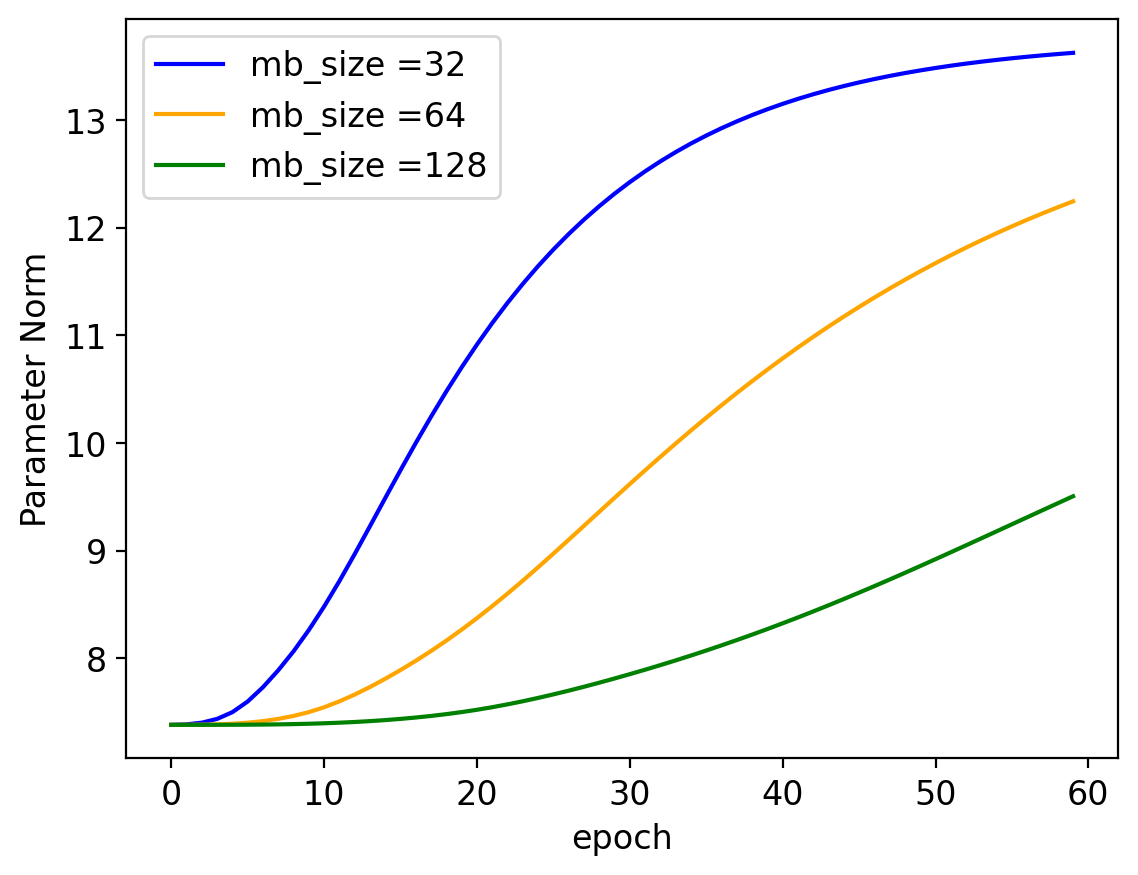

In [119]:
# Plot Parametric Norms
plt.plot(acc_dict['param_norm0'],c='blue',label='mb_size =' + str(batch_sizes[0]))
plt.plot(acc_dict['param_norm1'],c='orange',label='mb_size =' + str(batch_sizes[1]))
plt.plot(acc_dict['param_norm2'],c='green',label='mb_size =' + str(batch_sizes[2]))
plt.xlabel('epoch')
plt.ylabel('Parameter Norm')
plt.legend()
plt.show()
plt.show()

Here what observation can you make for different batch size. Why do you think this is happening?

## Pruning

Google is known for training very big language models and recently it trained a [trillion paramter](https://thenextweb.com/neural/2021/01/13/googles-new-trillion-parameter-ai-language-model-is-almost-6-times-bigger-than-gpt-3/) model. This is almost 1.2e6 times bigger than the models we have been training. So it is sufficient to say that these big models need intense compute power to train while also becomeing harder to deploy and get real time inference on smaller micro - proccesors. 

This is where regularization and pruning come in very handy. Until now you should have noticed that the Frobenious norm of the regularized models that we trained tend to be smaller than those of unregualrized models. This indicates that the regualarization is shrinking the weights (making the model sparser) while improving the test performance. 

While methods like L1 regularization promote implicit sparsity, in pruning we explicitly set a few weights of the trained model to zero and then retrain the model to adjust the other weights. This reduces the memory consumption, improves inference and helps the planet :)

One of the most common methods of pruning a NN is to zero out a certain percentage of parameters based on their L1 norm. We don't actually remove the parameters because that makes forward computation difficult.

Luckily we have Pytorch's torch.nn.utils.prune methods to play around and test pruning.


In [120]:
def prune_l1_unstructured(model,prune_percent_weight,prune_percent_bias = 0):

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prune_percent_weight)
            prune.l1_unstructured(module, name='bias', amount=prune_percent_bias)

            print(
                "Sparsity in {}: {:.2f}%".format(name,
                    100. * float(torch.sum(module.weight == 0))
                    / float(module.weight.nelement())
                )
            )



In [121]:
##uncomment to run the test
test_model = Animal_Net()
prune_percent = 0.15
prune_l1_unstructured(test_model,0.15)


Sparsity in fc1: 15.00%
Sparsity in fc2: 14.99%
Sparsity in fc3: 14.58%


Training a randomly initialized model


100%|██████████| 200/200 [00:19<00:00, 10.06it/s]


Pruning and verifying and model:
Sparsity in fc1: 50.00%
Sparsity in fc2: 50.00%
Sparsity in fc3: 50.00%
Training a pruned model


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


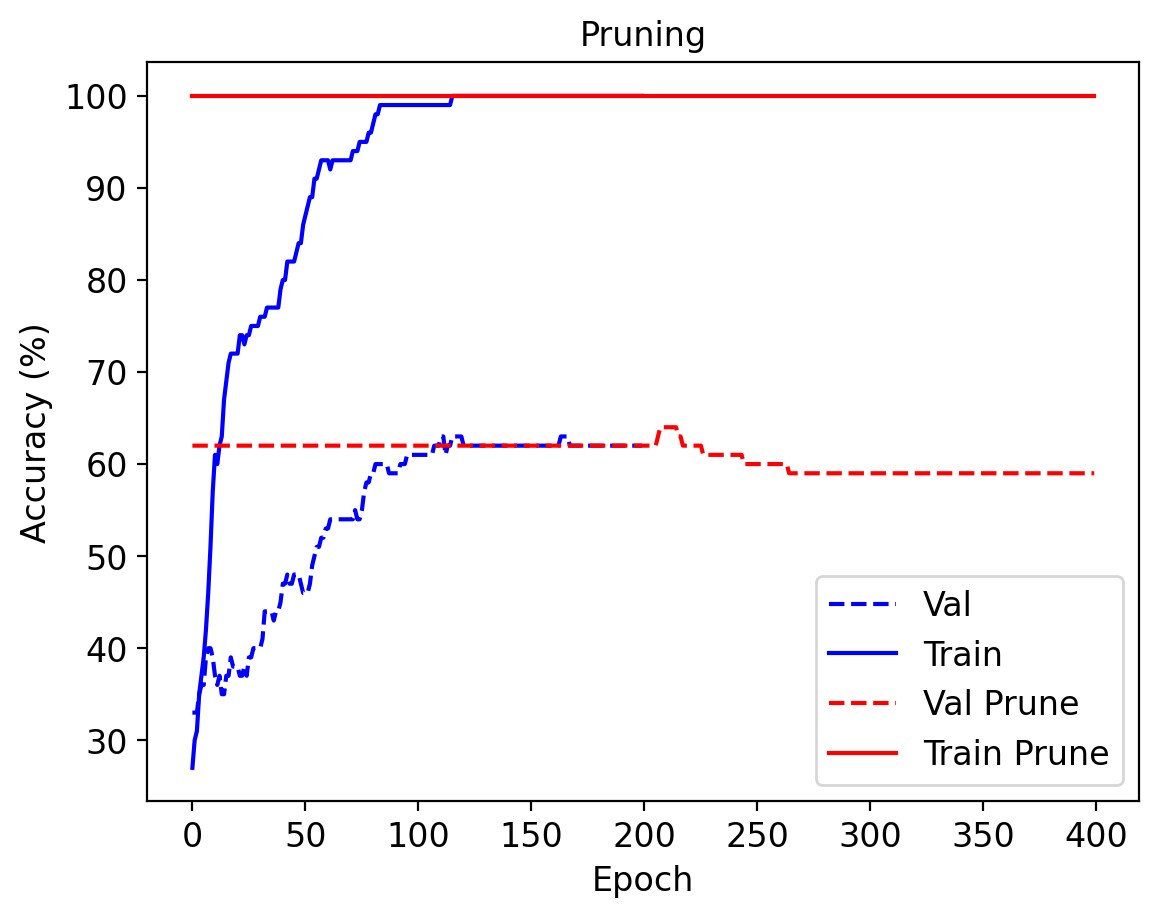

In [122]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 5e-3,
        'momentum': 0.9,
        'no_cuda': False
        }

acc_dict = {}
model = Big_Animal_Net()
prune_percent = 0.5

print("Training a randomly initialized model")
val_acc, train_acc, _, trained_model ,_ = main(args,model,train_loader,val_loader,img_test_dataset)

##pruning a model
print('Pruning and verifying and model:')
prune_l1_unstructured(trained_model,prune_percent)

#training the pruned model
print("Training a pruned model")
val_acc_prune, train_acc_prune, _, pruned_model ,_ = main(args,trained_model.to('cpu'),train_loader,val_loader,img_test_dataset)

val_acc_prune = [val_acc_prune[0]]*args['epochs'] + val_acc_prune
train_acc_prune = [train_acc_prune[0]]*args['epochs'] + train_acc_prune
plt.plot(val_acc,label='Val',c='blue',ls = 'dashed')
plt.plot(train_acc,label='Train',c='blue',ls = 'solid')
plt.plot(val_acc_prune,label='Val Prune',c='red',ls = 'dashed')
plt.plot(train_acc_prune,label='Train Prune',c='red',ls = 'solid')
plt.title('Pruning')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Now change the prune_percent and report the percentage at which the model underfits. Let us say you create a new model with number of parameters equal to the number of parameters left after pruning. Do you think this model will work as well as the model which get after pruning the larger network? In the above pruning technique after pruning the network, how do you think the performance of the will change if we re-initialize the weights while maintaing the prune mask?

### Pruning in Keras

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

## Lottery Tickets


The lottery ticket hypothesis claims that " A dense randomly initialized NN contains a subnetwork that is initialzed such that when trained in isolation it can match the test accuracy of the original network after training for at most same number of iterations" i.e. a pruned model when reinitialized with the same weights will can match the test accuracy of the denser model. If the initialization changes the accuracy match is no longer guaranteed.

Here we train the following networks:

An unregularized model with Xavier initialization of weights for 200 epochs
A Pruned model with the weights reinitialized to the random values.
A pruned model with weights initialized with same Xavier Initialization as unregularized model.

In [123]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'lr': 1e-3,
        'momentum': 0.9,
        'no_cuda': False,
        }

acc_dict = {}
init_model = Big_Animal_Net()
xavier_model = Big_Animal_Net()
prune_percent = 0.4


In [124]:
#Xavier Initilaization for one of the two models
for name, module in xavier_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)

print('Training the full model')
val_acc, train_acc, _, trained_model ,_ = main(args,copy.deepcopy(xavier_model),train_loader,val_loader,img_test_dataset)

Training the full model


100%|██████████| 200/200 [00:19<00:00, 10.03it/s]


In [125]:
#prune the trained model
prune_l1_unstructured(trained_model,prune_percent)

Sparsity in fc1: 40.00%
Sparsity in fc2: 39.99%
Sparsity in fc3: 40.10%


In [127]:
#initialize masks for the initialzed model and xavier model
for name, module in init_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        prune.identity(module, name='weight')
        prune.identity(module, name='bias')

for name, module in xavier_model.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        prune.identity(module, name='weight')
        prune.identity(module, name='bias')

init_modules = [[name,module] for name, module in init_model.named_modules()]
xavier_modueles = [[name,module] for name, module in xavier_model.named_modules()]
trained_modules = [[name,module] for name, module in trained_model.named_modules()]

for i in range(len(init_modules)):
    if isinstance(init_modules[i][1], torch.nn.Conv2d) or isinstance(init_modules[i][1], torch.nn.Linear):
        init_modules[i][1].weight_mask = copy.deepcopy(trained_modules[i][1].weight_mask) 
        init_modules[i][1].bias_mask = copy.deepcopy(trained_modules[i][1].bias_mask)

for i in range(len(xavier_modueles)):
    if isinstance(xavier_modueles[i][1], torch.nn.Conv2d) or isinstance(xavier_modueles[i][1], torch.nn.Linear):
        xavier_modueles[i][1].weight_mask = copy.deepcopy(trained_modules[i][1].weight_mask) 
        xavier_modueles[i][1].bias_mask = copy.deepcopy(trained_modules[i][1].bias_mask)

Training the pruned and Xavier model


100%|██████████| 200/200 [00:20<00:00,  9.62it/s]


Training the pruned Init model


100%|██████████| 200/200 [00:20<00:00,  9.62it/s]


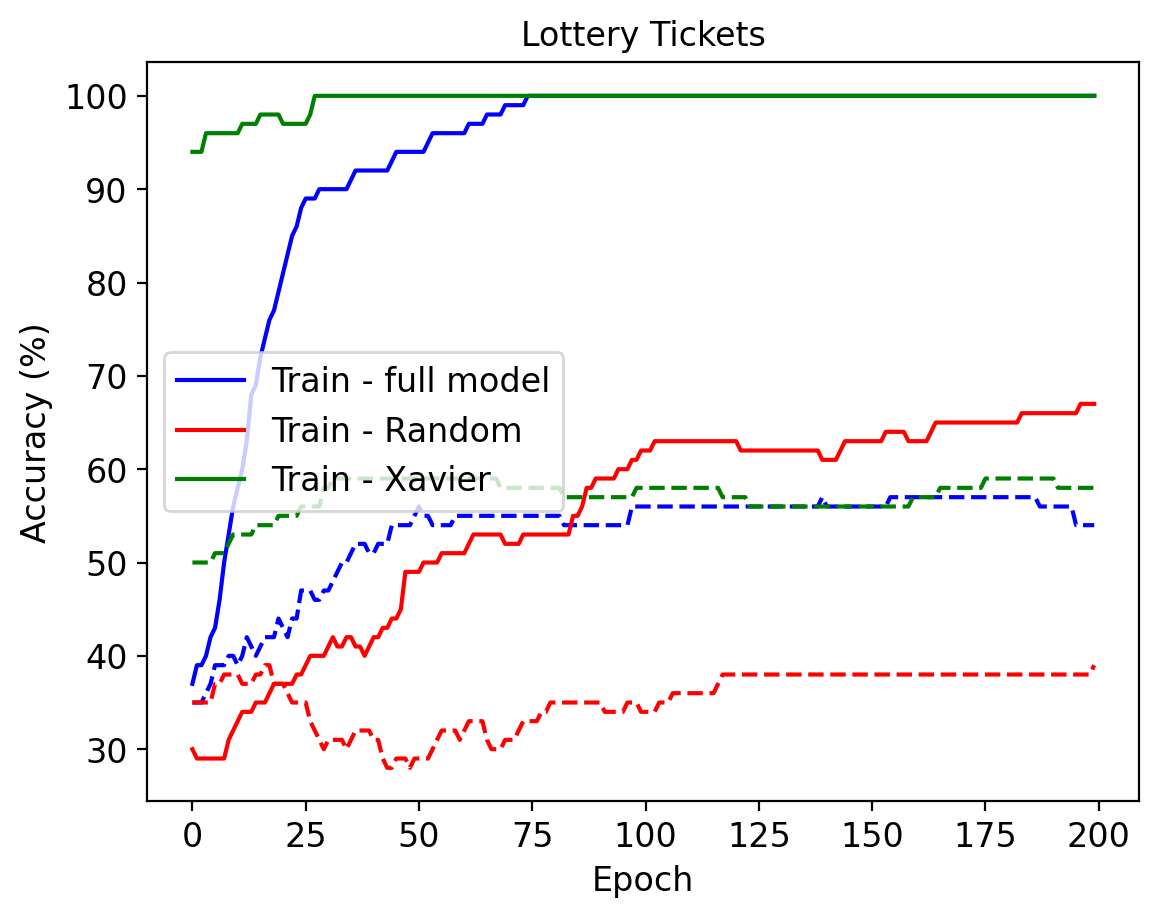

In [128]:
print('Training the pruned and Xavier model')
val_acc_lottery_x, train_acc_lottery_x, _, pruned_model_x ,_ = main(args,xavier_model,train_loader,val_loader,img_test_dataset)
print('Training the pruned Init model')
val_acc_lottery, train_acc_lottery, _, pruned_model ,_ = main(args,init_model,train_loader,val_loader,img_test_dataset)

plt.plot(val_acc,c='blue',ls = 'dashed')
plt.plot(train_acc,label='Train - full model',c='blue',ls = 'solid')
plt.plot(val_acc_lottery,c='red',ls = 'dashed')
plt.plot(train_acc_lottery,label='Train - Random',c='red',ls = 'solid')
plt.plot(val_acc_lottery_x,c='green',ls = 'dashed')
plt.plot(train_acc_lottery_x,label='Train - Xavier',c='green',ls = 'solid')
plt.title('Lottery Tickets')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


### Lottery Ticket in Keras

Keras Option: https://github.com/google-research/lottery-ticket-hypothesis

## Distillation



Bigger neural nets are better for model performance but require significant memory, while smaller networks tend be be less accurate but are easier to deploy and use. 

Distillation is a technique which allows us to train smaller networks such that they mimic the outputs of the bigger network. The bigger network is called the teacher network wheras the smaller one is the student network. 

Distillation begins by training a teacher network. It then trains the student network with both the original labels and "soft" labels--the output of the teacher model. This lets us train the student network on unlabelled datasets, using the labeled given by the teacher network. 

Let's begin by desiging a smaller network and training the parent model and also the small model using hard labels.

In [130]:
class Small_Animal_Net(nn.Module):
    def __init__(self):
        torch.manual_seed(32)
        super(Small_Animal_Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [131]:
#Train the models 
args = {'test_batch_size': 1000,
        'epochs': 200,
        'momentum': 0.9,
        'no_cuda': False,
        'lr' : 5e-3,
        'cross_entropy':True
        }

Bmodel = Big_Animal_Net()
Smodel = Small_Animal_Net()

val_acc_big, train_acc_big, _, trained_big_model ,_ = main(args,Bmodel,train_loader,val_loader,img_test_dataset)
val_acc_small, train_acc_small, _, _ ,_ = main(args,Smodel,train_loader,val_loader,img_test_dataset)

100%|██████████| 200/200 [00:18<00:00, 10.81it/s]


Loss Function:

We use the same cross entropy loss as before but we use both hard and soft labels to calculate loss. We cannot directly use the CrossEntropy Loss in Pytorch to calculate loss for soft labels. Hence we will exploit the relation between Cross Entropy and KL Divergence. 

Cross Entropy loss and KL Divergence are both related by: H(p,q) = H(p) + KL(p,q) where H(p,q) calculates cross entropy loss between distributions p and q wheras KL represents KL divergence. Here p is the probability distribution of soft_outputs which are constant and hence we can omit from the loss function.

        L = (1 - alpha)*CE(outputs,ground_truth) + alpha * (T**2) *CE(outputs,soft_targets)
        L = (1 - alpha)*CE(outputs,ground_truth) + alpha * (T**2) *KL(outputs,soft_targets)

Here alpha and temperature are hyper parameters where temperatures is used to smoothen the outputs of the parent network. 

[Click to learn more about the relation](https://adventuresinmachinelearning.com/cross-entropy-kl-divergence/)

In [132]:
def distillation_loss(args,soft_outputs, pred_logits, target):

    alpha = args['alpha']
    T = args['temperature']
    dist_loss = (1. - alpha) * F.cross_entropy(pred_logits, target) + \
                    (alpha * (T ** 2)) * F.kl_div(F.log_softmax(pred_logits/T, dim=1),
                             F.softmax(soft_outputs/T, dim=1))

    return dist_loss

In [133]:
#Modified Train Functions 
def train_softmax_distillation(args, student_model,parent_model, device, train_loader, optimizer, epoch):
    
    student_model.train()
    parent_model.eval()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        soft_outputs = parent_model(data)
        pred_logits = student_model(data)
        loss = distillation_loss(args,soft_outputs.detach(), pred_logits, target)
        loss.backward()
        optimizer.step()

In [134]:
#Modified Main Function
def distilation_main(args, teacher_model,student_model,train_loader,val_loader):

    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

    student_model = student_model.to(device)
    teacher_model = teacher_model.to(device)
    optimizer = optim.SGD(student_model.parameters(), lr=args['lr'], momentum=args['momentum'])
    val_acc_list = []
    train_acc_list = []
    for epoch in tqdm(range(1, args['epochs'] + 1)):
        train_softmax_distillation(args, student_model,teacher_model, device, train_loader, optimizer, epoch)
        train_acc = test(student_model,device,train_loader,'Train')
        val_acc = test(student_model,device,val_loader,'Val')
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)

    return val_acc_list, train_acc_list, student_model

Now that we have everything ready let's train the student network.

In [135]:
args = {'test_batch_size': 1000,
        'epochs': 200,
        'momentum': 0.9,
        'no_cuda': False,
        'lr' : 5e-3,
        'alpha': 1,
        'temperature': 40
        }

student_model = Small_Animal_Net()

val_acc_st, train_acc_st, _, = distilation_main(args,trained_big_model,student_model,train_loader,val_loader)

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\parth\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 200/200 [00:18<00:00, 10.67it/s]


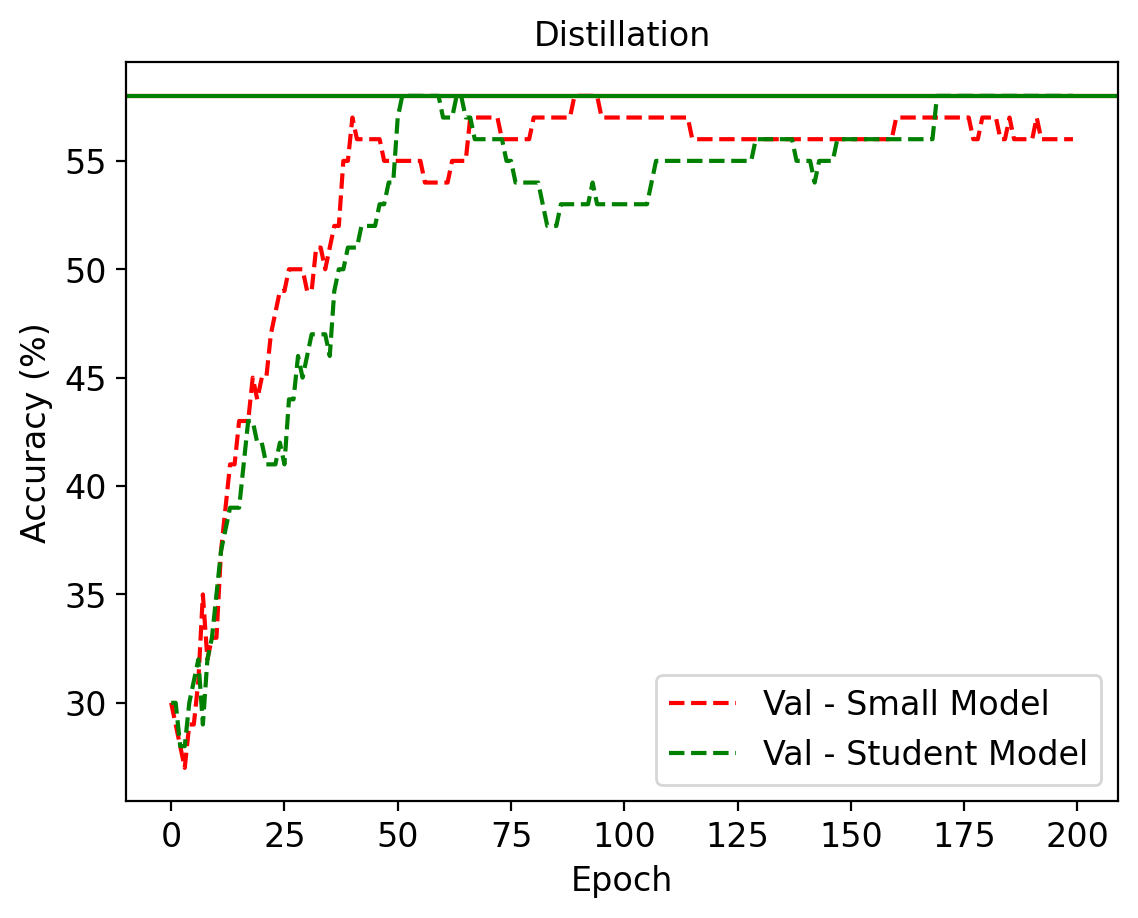

In [136]:
# Plot the validation curves of student and the original small model 
plt.plot(val_acc_small,label='Val - Small Model',c='red',ls = 'dashed')
plt.axhline(y = max(val_acc_small),c = 'red')
plt.plot(val_acc_st,label='Val - Student Model',c='green',ls = 'dashed')
plt.axhline(y = max(val_acc_st),c = 'green')
plt.title('Distillation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

This method not only provides a way to train small and better networks but also gives us a chance to train small networks on more data using the soft labels from the heavily optimized parent networks.

What other techniques can you use to reduce the dimensionality or size of the big network or the input data?

Do you think regularization helps when you have infinite data available?

Which regualarization technique from this week do you think had the biggest effect on the network and why do you think so? Can you apply all of them on the same network?

### Distillation in Keras

https://keras.io/examples/vision/knowledge_distillation/

# Homework Notebooks

In the last notebook, you trained your own Keras or PyTorch models on data of your choice. In this notebook, you are going to use those models (you can also train new models), and use different optimization and regularisation techniques on them. 

You will be graded for 4 out of 6 of the modeling methods you use.

**1)** Build or reuse an older model you have built, and use 3 different optimization techniques or methods on the model. For one of these models, add a batch normalization layer. 

**1a)** Which optimizer performed the best? How did Batch Normalization method effect your model?

**2)** Build or reuse an older model you have built, and use 3 different Regularization techniques or methods on the model. You will get bonus points if you use Pruning, Distillation, or the Lottery Ticket Hypothesis. 

**2a)** Which regularisation technique worked best? 